# Assigning translation tasks in Unbabel

Unbabel is an artificial intelligence-powered human translation platform. It translates text to clients using a machine translation through artificial intelligence, followed by a human post edition of the machine translation. Clients send texts for translation and Unbabel stored them as tickets. Those tickets are then split into tasks that have a maximum of $40$-words. These tasks are then assigned to the human translators we here call _post editors_, who will edit the machine translation and make sure the translation is sent to the client with the maximum quality possible.

The challenge is to maximize the quality of translation in each task and its stability while assuring all editors have translation tasks. We must find a way to assign tasks that addresses two main complaints:
1. Clients complain that task quality is not stable - in the end, this actually means they have some low quality tasks they did not expect;
2. A large group of editors is has no translation tasks to deliver.

Here we will assign the translation tasks in order to address these issues.

### Information available
- Editor profile, stored in the `post_editors` data frame
- Client profile, in the data frame `clients`
- The translation tickets requested, in the `tickets` data frame
- The translation `tasks`. Each translation ticket was divided into tasks with a maximum length of $40$ words.

# Table of Contents

[Importing the packages](#packages)

[Importing the tables](#tables)

[Exploring and visualizing the data](#exploring)
 - [Skill profile in all domains](#skill_profile)
 - [Task and client profiles](#task_client_profile)
 - [Number of words per task](#words_task)
 - [Maximum skill of a post editor](#maximum_skill)

[Maximum number of tasks to assign per editor](#maximum_tasks)

[Calculating probabilities  𝑃(𝐴) and  𝑃(𝐴|𝐸) needed to estimate task quality](#calculating_both_probabilities)
 - [Calculating and plotting  𝑃(𝐴)](#P(A))
 - [Calculating and plotting  𝑃(𝐴|𝐸)](#P(A|E))

[Language pairs of the editors](#language_pairs)

[Initial task assignment to the editors](#initial_task_assignment)

[Optimizing task assignments](#simulated_annealing)

[Stringent optimization](#stringent)

[Recommendations](#recommendations)

<a id='packages'></a>
## Importing the packages

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import threading

random.seed(24)

Importing functions developed separately in the Python file `UnbabelOptimizer.py`

In [135]:
from UnbabelOptimizer import plot_skill_hist, editor_skills, Prob_A_plot, Prob_A_given_E_plot, editor_skill_for_task, quality, objective_function, metropolis, first_assignment_plots, assignment_by_domain_plots, optimization_plots

<a id='tables'></a>
## Importing the tables

The editors table as `post_editors`, the `clients` table, the translation `tickets` table and the translation `tasks` table.

In [136]:
post_editors = pd.read_csv('C:/Users/Samsung/Documents/Data Science Challenge/editors.csv',usecols=['id','travel','fintech','ecommerce','sports','gamming','health_care'])
clients = pd.read_csv('C:/Users/Samsung/Documents/Data Science Challenge/clients.csv',usecols=['id','domain','category'])
tickets = pd.read_csv('C:/Users/Samsung/Documents/Data Science Challenge/tickets.csv',usecols=['id','client_id','number_words','tone','language_pair','quality_score','price','client_id.1'])
tasks = pd.read_csv('C:/Users/Samsung/Documents/Data Science Challenge/tasks.csv',usecols=['id','number_words','sequence_number','ticket_id'])

In [137]:
clients.head()

,id,domain,category
0,8171ce8697ccbc42991a2eca38cbdee8f96fd794701aa1...,ecommerce,Medium
1,203f6f43688c9abe2e66df55828826f1e04815fa1bf289...,ecommerce,Small
2,896eaafb9691dd3992336145e0b80bb71fdcded7fca603...,health_care,Enterprise
3,84506a2e169143888f4e1c7afe5bc52699ca5cf1b6cc2e...,fintech,Enterprise
4,19388f0b6133ef2085e26dfc50b046836f9aada571cbd8...,fintech,Enterprise


In [138]:
post_editors.head()

,id,travel,fintech,ecommerce,sports,gamming,health_care
0,dd2a4a379c04b944834c66cc797815f0f6b01c10858e8b...,2,4,4,2,5,3
1,2f5da6e9921baa794759ee9f4b362555bcb3c1646eb51f...,3,3,4,5,3,5
2,534599df3b467cfe814e0a4a979cc9726b64d189247e92...,4,3,1,2,1,4
3,2f8308ae8b2b2f57f17d96c86457b4f219242999399697...,3,2,5,5,3,1
4,9865f5293dce01180593e9329dff57a1ac9a41d33afef7...,3,2,4,4,4,5


In [139]:
tickets

,id,client_id,number_words,tone,language_pair,quality_score,price,client_id.1
0,C05739545,87.0,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...
1,C05739547,32.0,172,formal,pt_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...
2,C05739550,32.0,344,informal,pt_en,-1,-1,36b322832c268a1fa9e64b30dc6490c6591d4b38ae28d2...
3,C05739554,80.0,1436,informal,fr_de,-1,-1,89225a3eb6c39c319e0175a029402b7d07bfba033fdba2...
4,C05739559,80.0,163,informal,pt_en,-1,-1,896eaafb9691dd3992336145e0b80bb71fdcded7fca603...
...,...,...,...,...,...,...,...,...
7783,C05778462,180.0,364,informal,pt_en,-1,-1,08790ec4a07f4ea4f0aca6da75882c7bb044c29fe642b0...
7784,C05778463,180.0,138,formal,fr_de,-1,-1,36b322832c268a1fa9e64b30dc6490c6591d4b38ae28d2...
7785,C05778465,116.0,1288,informal,es_ja,-1,-1,72d26122e4aef9be62176640b5f185009fa0b9fb94cb77...
7786,C05778466,143.0,125,formal,pt_en,-1,-1,df809fcbd44f05b842f1c80d98119a0b3d6f7cd51b611d...


Each client generates hundreds of tickets.

In [140]:
tickets['client_id.1'].value_counts().describe()

count     50.000000
mean     155.760000
std       10.979684
min      138.000000
25%      148.250000
50%      154.000000
75%      165.500000
max      181.000000
Name: client_id.1, dtype: float64

Therefore, each client can assess the consistency in task quality both within each ticket and among tickets. This means that sorting tasks randomly within each ticket or sorting different tickets separately to different editors will likely have similar effects on the task quality consistency perceived by each client.

For this reason, we will sort the tickets along the editors, which is the simplest procedure.

In [141]:
tasks

,id,number_words,sequence_number,ticket_id
0,L139WPBDIEJG4PD2FOAWDMGC0XLFVEJO,40,1,C05739545
1,QKADER8M3USE69QGU1DPZRVAUZX8WDJI,40,2,C05739545
2,7FA5ED3SSU5QC2TNBX1Y3TOZDDVJ60ZY,40,3,C05739545
3,AUGNZGL3HUUKQICO2URO4VBA6TJPC1SI,22,4,C05739545
4,D3DUPMUSC7ZOX9DD3G8NP2CPUWNRH835,40,1,C05739547
...,...,...,...,...
83148,AQW7R0PBHGI5E6VR5CJ6DTGNJ2GF7JEK,40,4,C05778470
83149,22E7RNUJ49KIRDCD32HAU3B9KWBSYGRR,40,5,C05778470
83150,NNW9XM9E7IXHKGOZ6NDED8GCWQ0G9OBU,40,6,C05778470
83151,S746YBUFG2ZVM4AGC47N9662KOMYX6IG,40,7,C05778470


Because the $7788$ tickets were partitioned into $83153$ tasks, by assorting individual tasks we also minimize our chances of having idle editors.

In [142]:
#Merging client information with the tickets table through an inner join by the client id
tickets_extended = pd.merge(tickets,clients, how='inner',left_on='client_id.1',right_on='id',suffixes=("_t","_c"))
tickets_extended

,id_t,client_id,number_words,tone,language_pair,quality_score,price,client_id.1,id_c,domain,category
0,C05739545,87.0,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
1,C05739673,150.0,1010,informal,fr_de,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
2,C05739811,32.0,491,formal,es_ja,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
3,C05758424,80.0,59,formal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
4,C05758447,80.0,890,formal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
...,...,...,...,...,...,...,...,...,...,...,...
7783,C05775599,80.0,178,formal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7784,C05776045,80.0,77,informal,pt_en,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7785,C05776989,158.0,593,formal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7786,C05777030,80.0,73,informal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small


In [143]:
# Removing duplicated columns from that extended table
tickets_extended.drop(['client_id','client_id.1'], axis=1, inplace=True)
tickets_extended

,id_t,number_words,tone,language_pair,quality_score,price,id_c,domain,category
0,C05739545,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
1,C05739673,1010,informal,fr_de,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
2,C05739811,491,formal,es_ja,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
3,C05758424,59,formal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
4,C05758447,890,formal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
...,...,...,...,...,...,...,...,...,...
7783,C05775599,178,formal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7784,C05776045,77,informal,pt_en,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7785,C05776989,593,formal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
7786,C05777030,73,informal,es_ja,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small


In [144]:
#Merging the information on the extended table above with the tasks table through an inner join by the ticket id
tasks_all = pd.merge(tasks,tickets_extended, how='inner',left_on='ticket_id',right_on='id_t',suffixes=("_ts","_ti"))
tasks_all.drop(['id_t'],axis=1,inplace=True)
tasks_all

,id,number_words_ts,sequence_number,ticket_id,number_words_ti,tone,language_pair,quality_score,price,id_c,domain,category
0,L139WPBDIEJG4PD2FOAWDMGC0XLFVEJO,40,1,C05739545,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
1,QKADER8M3USE69QGU1DPZRVAUZX8WDJI,40,2,C05739545,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
2,7FA5ED3SSU5QC2TNBX1Y3TOZDDVJ60ZY,40,3,C05739545,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
3,AUGNZGL3HUUKQICO2URO4VBA6TJPC1SI,22,4,C05739545,142,informal,pt_en,-1,-1,587fb1667c89615c53088cce45b602cc03ef251bcaf9e0...,travel,Enterprise
4,D3DUPMUSC7ZOX9DD3G8NP2CPUWNRH835,40,1,C05739547,172,formal,pt_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...,travel,Small
...,...,...,...,...,...,...,...,...,...,...,...,...
83148,AQW7R0PBHGI5E6VR5CJ6DTGNJ2GF7JEK,40,4,C05778470,317,formal,nl_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...,travel,Small
83149,22E7RNUJ49KIRDCD32HAU3B9KWBSYGRR,40,5,C05778470,317,formal,nl_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...,travel,Small
83150,NNW9XM9E7IXHKGOZ6NDED8GCWQ0G9OBU,40,6,C05778470,317,formal,nl_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...,travel,Small
83151,S746YBUFG2ZVM4AGC47N9662KOMYX6IG,40,7,C05778470,317,formal,nl_en,-1,-1,a59b8fa90a633fd2902283bfbe4dffa9c06e3420c03df5...,travel,Small


Now we have the two main tables we will use in this solution, `post_editors` and `tasks_all`.

<a id='exploring'></a>
## Exploring and visualizing the data

<a id='skill_profile'></a>
### Skill profile in all domains

Looking at editor skills in each domain, we see that the skill profile is modest. In the travel domain, there is a clear lack of skills.

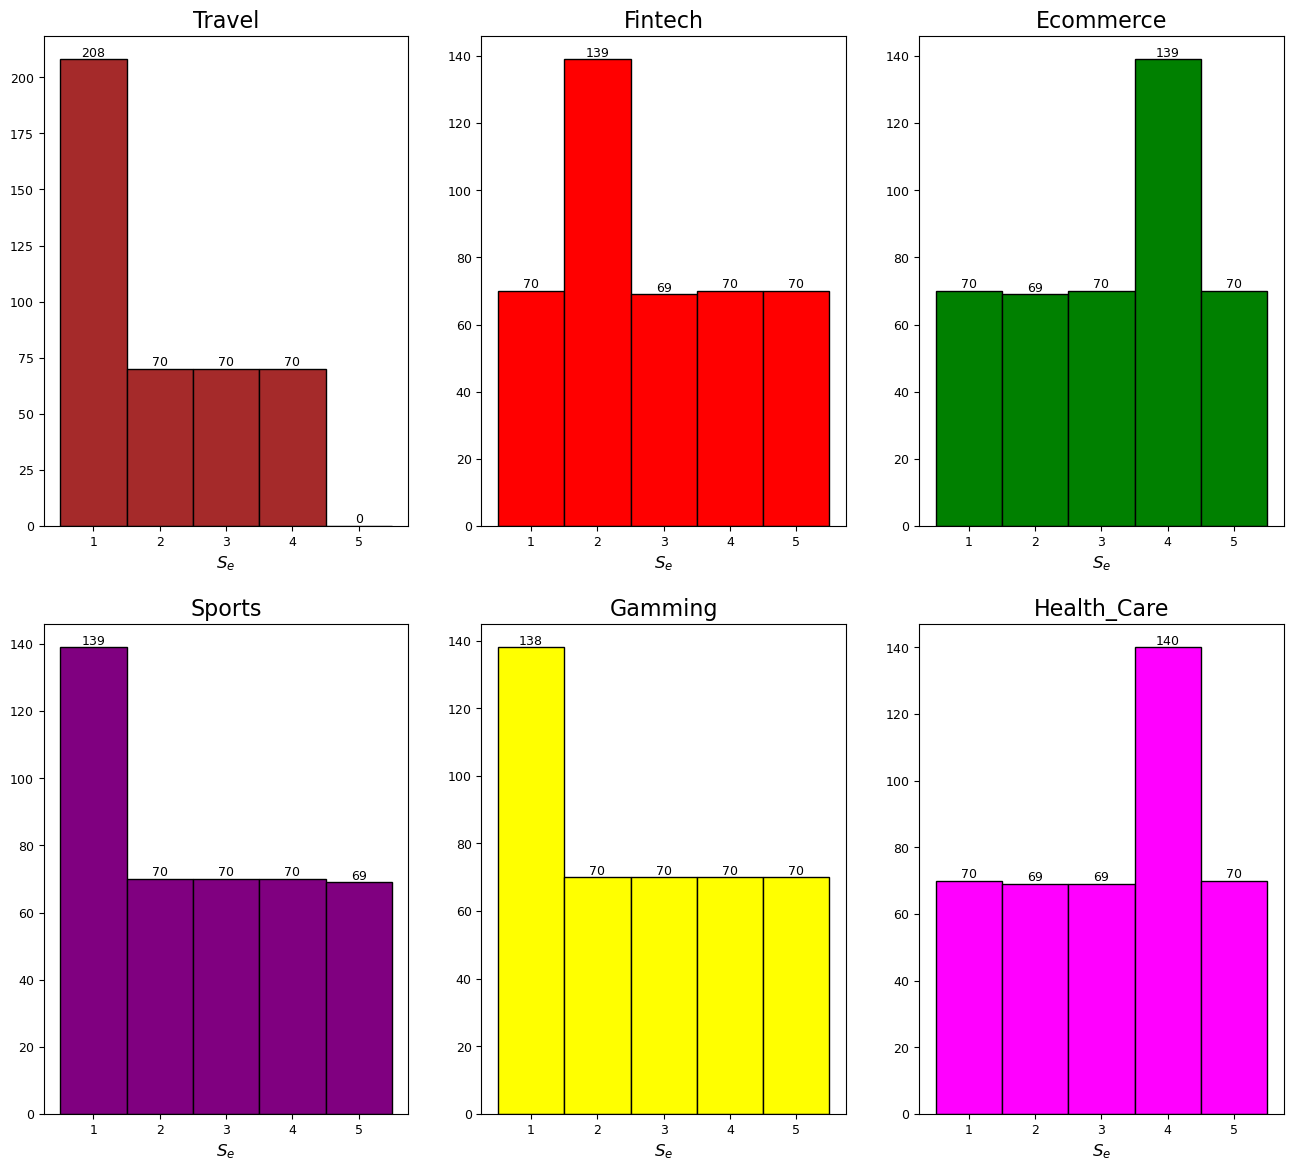

In [145]:
fig, ax = plt.subplots(2,3,figsize=(16,14))
plot_skill_hist(post_editors,ax,'travel','brown',0,0)
plot_skill_hist(post_editors,ax,'fintech','red',0,1)
plot_skill_hist(post_editors,ax,'ecommerce','green',0,2)
plot_skill_hist(post_editors,ax,'sports','purple',1,0)
plot_skill_hist(post_editors,ax,'gamming','yellow',1,1)
plot_skill_hist(post_editors,ax,'health_care','magenta',1,2)
plt.show()

As expected, the average skill is modest in all domains and the travel domain has the lowest average skill among our editors, which is much lower than desirable.

In [146]:
skill_mean_by_domain = post_editors[['travel','fintech','ecommerce','sports','gamming','health_care']].mean(axis=0).sort_values(ascending=False)
skill_mean_by_domain

health_care    3.169856
ecommerce      3.167464
fintech        2.834928
gamming        2.674641
sports         2.665072
travel         2.004785
dtype: float64

<a id='task_client_profile'></a>
### Task and client profiles

On top of this, we can see a very high prevalence of the travel sector among our tasks. Almost half of the tasks and clients belong to the travel sector. This clearly shows that the demand in which we have the lowest skill overall is unfortunately the domain for which we have the highest demand for translations. 

This is a key reason for the issues we are trying to solve.

(0.0, 45000.0)

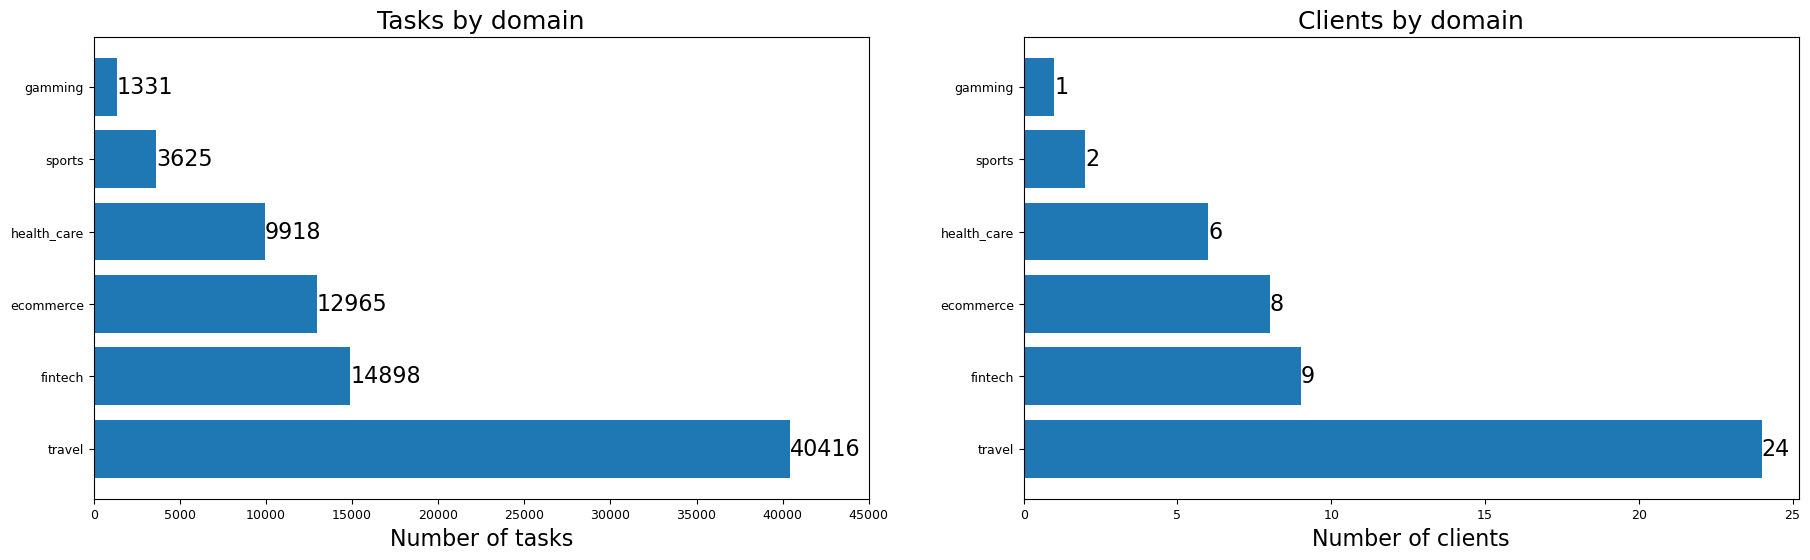

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))
plt.rcParams['font.size'] = 16
domains = tasks_all['domain'].value_counts().index.to_list()
ax1.set_title('Tasks by domain',fontdict={'fontsize':18})
ax1.set_xlabel('Number of tasks',fontdict={'fontsize':16})
ax2.set_title('Clients by domain',fontdict={'fontsize':18})
ax2.set_xlabel('Number of clients',fontdict={'fontsize':16})
bar1 = ax1.barh(domains,tasks_all['domain'].value_counts())
bar2 = ax2.barh(domains,clients['domain'].value_counts())
ax1.bar_label(bar1)
ax2.bar_label(bar2)
ax1.set_xlim(0,45000)

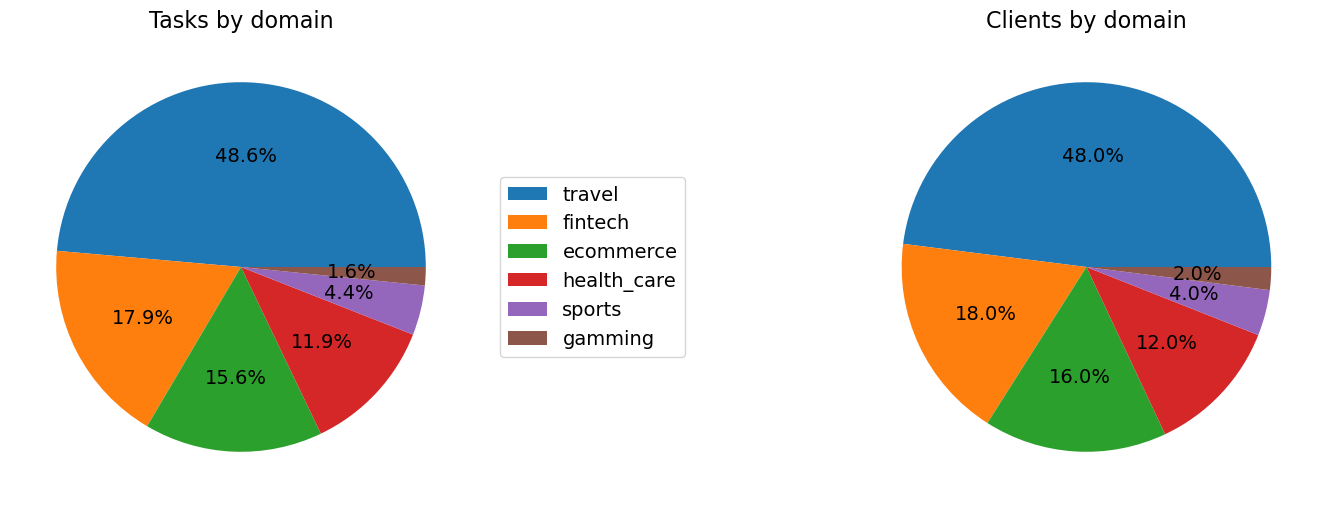

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plt.rcParams['font.size'] = 14
domains = tasks_all['domain'].value_counts().index.to_list()
ax1.set_title('Tasks by domain',fontdict={'fontsize':16})
ax2.set_title('Clients by domain',fontdict={'fontsize':16})
ax1.pie(tasks_all['domain'].value_counts(),autopct='%1.1f%%')
ax2.pie(clients['domain'].value_counts(),autopct='%1.1f%%')
ax1.legend(domains,loc='center left',bbox_to_anchor=(1.04, 0.5))

<a id='skill_correlation'></a>
### Skill correlation among domains

On another hand, we can see there is little correlation between skills of editors in different domains. The highest value is $0.21$, between sports and gaming skills, but even if that value is statistically significant, it amounts to a low correlation level. This means that, in general, we shall not have conflitual choices regarding which task domains we should assign to a given editor.

<Axes: >

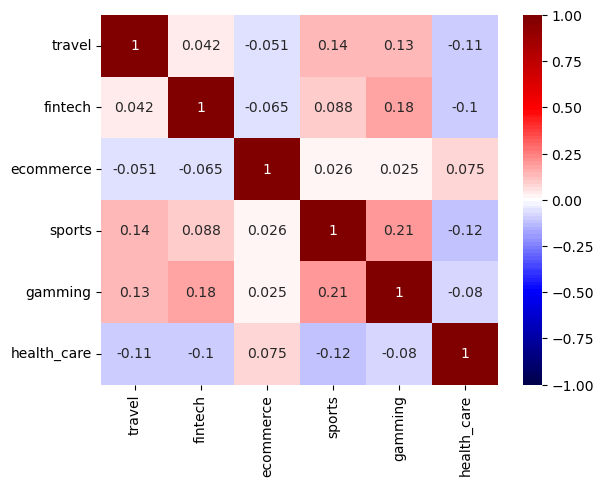

In [149]:
domain_corr = post_editors[['travel','fintech','ecommerce','sports','gamming','health_care']].corr()

# create colour map. We take 101 values equally spaced between 0 and 1
# hence the first value 0, second value 0.01
c = np.linspace(0,1,101)
# For those values we store the colours from the "YlOrRd" map in an array
colours = plt.get_cmap("seismic",101)(c)
# We create a new colour map with the colours
seismic_cmap = matplotlib.colors.ListedColormap(colours)

plt.rcParams['font.size'] = 10
sns.heatmap(domain_corr, annot=True,center=0,vmin=-1,vmax=1,cmap=seismic_cmap)

<a id='words_task'></a>
### Number of words per task

As expected, almost all tasks have $40$ words. At least $90\%$ of the tasks have $39$ or $40$ words in length and $1\%$ has $6$ words or less, in all domains.

In [150]:
tasks_all.groupby(['domain'])['number_words_ts'].describe(percentiles=[0.01,0.03,0.05,0.08,0.1,0.12])

,count,mean,std,min,1%,3%,5%,8%,10%,12%,50%,max
domain,,,,,,,,,,,,
ecommerce,12965.0,38.197995,6.581267,1.0,5.00,14.0,23.0,34.0,40.0,40.0,40.0,40.0
fintech,14898.0,38.233857,6.484154,1.0,5.00,15.0,22.0,35.0,40.0,40.0,40.0,40.0
gamming,1331.0,37.909842,7.020442,1.0,4.30,14.0,19.0,29.0,39.0,40.0,40.0,40.0
health_care,9918.0,38.193587,6.614192,1.0,4.17,14.0,22.0,35.0,40.0,40.0,40.0,40.0
sports,3625.0,38.483862,5.997316,1.0,6.00,17.0,27.0,40.0,40.0,40.0,40.0,40.0
travel,40416.0,38.183912,6.633656,1.0,5.00,14.0,22.0,34.0,40.0,40.0,40.0,40.0


<a id='maximum_skill'></a>
### Maximum skill of a post editor

The maximum skill of a post editor ranges between $2$ and $5$. There is no editor with skill $1$ in all domains.

In [151]:
maximum_editor_skill = post_editors.loc[:,['travel','fintech','ecommerce','sports','gamming','health_care']].max(axis=1)
maximum_editor_skill.value_counts()

5    235
4    157
3     23
2      3
dtype: int64

This probably means that skill-$1$-editors are discarded from Unbabel's pool of post editors, whereas skill $2$ editors are not. For this reason, I shall not count on skill-$1$-editors to perform tasks, but I shall count on editors with a skill of $2$ and above and assign tasks to them all in case of need.

<a id='maximum_tasks'></a>
## Maximum number of tasks to assign per editor

If we were to consider a quality criterion alone, we would only give tasks to the most skilled editors, but that would lead to a few overwhelmed, skillful editors and a lot of idle, low-skilled editors. On the other hand, in order to assort tasks to all editors, we have to give tasks to lower-skill editors, thereby sacrificing task quality. Why shall we do such a thing? Because each task takes time and all services must be time-bounded. Delivering a very high quality task to the client after a very long waiting time also constitutes a bad service to the clients.

[Unbabel's translation times are public to all prospective clients](https://help.unbabel.com/hc/en-us/articles/14860821686039-Translation-Times): a high-quality translation of $1000$ words should be delivered to the client in $2$ days. As we know that tickets are divided into $40$-word tasks, this means that in 2 days we shall have $25$ tasks completed.

Therefore, the time we are allowed to take to translate tasks depends on the number of words each client is submitting for translation. We can see that the client that has submitted the least amount of words for translation has submitted $44534$ words.

In [152]:
number_words_per_client = tickets_extended.groupby('id_c')['number_words'].sum().sort_values(ascending=True)
number_words_per_client

id_c
a23cd6eeec0720abcfb286b6222e7b9db073b9f789a5a85523da96743016b575    44534
72d26122e4aef9be62176640b5f185009fa0b9fb94cb77c6c31d94281a178228    45250
203f6f43688c9abe2e66df55828826f1e04815fa1bf289771cb530500df02ca8    47318
6f053273db5aca5095bea082c7125096e5414d07e417cf9f45d3880315bba9f9    47399
a0cc582a1d5abfc275a510f69e556a9d4ce8429f7986cf3418df28f066665c11    48153
dcecd7919c995b8621d1e76ac4aa6a5aaa9b47ddac682095148e5838e483febd    49241
3b93e4dee2a994d9a9e1f8af90081e7b6e1d41a6b1550e65cf013b6028c666ce    50458
48e6b11c6636388248ad5ae844addedac6c954f65c3d96c3f647ff7ea98a8ec5    51845
18ed578fb9a74e501b2cb547bd2ecd8d49c5a5e2aa6a192547de2a5608944a72    52309
35b1a7722289e1b6d51c0c16f6925321bdd7ab58ceeea3a73f7621595ace23f8    55074
89225a3eb6c39c319e0175a029402b7d07bfba033fdba2bb439ee40bbda226fa    55472
100f082c2cbfd1327676ad93e5c8e7b8d44aa419f7b398f71d9572c29b09b66c    55951
9ff6a362b235664a23378df54308c5c82c6000c5536462213a35b2a8ecdfee1a    56029
552e63435c303050a48f595d30286ef2e

Given the translation times we mentioned before, we will have $90$ days to translate those words to that client.

In [153]:
math.ceil(number_words_per_client[0]/1000*2)

90

I will use that client as a reference. We will assign tasks in a way that ensures that all tasks are delivered to the clients in $90$ days. Given that Unbabel is expected to complete $25$ tasks in 2 days, we shall assign no more than $25 \times 90 / 2 = 1125$ tasks to a given editor in order to complete all these tasks in $90$ days.

Tasks in 2 days | Tasks per week (5 days) | Tasks in 90 days
---|---|---
$25$| $62$ | $1125$

<a id='calculating_both_probabilities'></a>
## Calculating probabilities $P(A)$ and $P(A|E)$ needed to estimate task quality

<a id='P(A)'></a>
### Calculating and plotting $P(A)$

Below I define a probability function for $P(A)$ for each domain $d$.

Since we have $S = 5$ $-$ we have $5$ different values of skill $-$, our quality space $Q$ will have $S-1=4$ buckets of quality intervals. I have to transform $5$ levels of skill into $4$ quality intervals. As we have a quality $Q(t)$ of task $t$ with integer values from $1$ to $100$, we can say that:

- $1 \leq Q(t) \leq 20 \implies S_d(E) = 1 $
- $21 \leq Q(t) \leq 40 \implies S_d(E) = 2 $
- $41 \leq Q(t) \leq 60 \implies S_d(E) = 3 $
- $61 \leq Q(t) \leq 80 \implies S_d(E) = 4 $
- $81 \leq Q(t) \leq 100 \implies S_d(E) = 5 $

In terms of quality intervals $A$, we can say that:
- $1 \leq Q(t) \leq 25 \implies A = 1: \space$  The whole $S(E)=1$ space \$([1-20])$ and $1/4$ of the $S(E)=2$ space $([21-25])$

- $26 \leq Q(t) \leq 50 \implies A = 2: \space$ $3/4$ of the $S(E)=2$ space \$([26-40])$ and half of the $S(E)=3$ space $([41-50])$

- $51 \leq Q(t) \leq 75 \implies A = 3: \space$ half of the $S(E)=3$ space \$([51-60])$ and $3/4$ of the $S(E)=4$ space $([61-75])$

- $76 \leq Q(t) \leq 100 \implies A = 4: \space$ $1/4$ of the $S(E)=4$ space \$([76-80])$ and  the whole $S(E)=5$ space $([81-100])$

For this reason, I have defined the following probability mass function for the quality intervals:

$A$ |$P(A)$
 ---|---
 $1$|$P(S_d(E)=1) + \frac{1}{4} P(S_d(E)=2)$
 $2$|$\frac{3}{4} P(S_d(E)=2) + \frac{1}{2} P(S_d(E)=3)$
 $3$|$\frac{1}{2} P(S_d(E)=3) + \frac{3}{4} P(S_d(E)=4)$
 $4$|$\frac{1}{4}P(S_d(E)=4) + P(S_d(E)=5)$

 
 where $P(S_d(E)=k)$ is the probability of having an editor of skill $k$ in domain $d$, which I have considered to be equal to the relative frequencies of editors of the respective skills in our pool of editors.
 For instance, if we have $208$ editors with skill $1$ in the travel sector out of the total of $418$ editors, then
 
$$P(S_{travel}(E)=1) = \frac{208}{418} = \frac{104}{209}$$

In [154]:
domains = skill_mean_by_domain.index.to_list()

#Absolute frequency of each editor skill in each domain
editor_skills_domains = {domain: editor_skills(post_editors,domain) for domain in domains}
editor_skills_domains

#Given that we have 4 buckets for 5 skill levels, we can write P(A) as a function of skill probability, using relative frequencies
#(absolute frequency divided by total number of editors)
Prob_A = {domain:[(editor_skills_domains[domain][0]+1/4*editor_skills_domains[domain][1])/len(post_editors),
              (3/4*editor_skills_domains[domain][1]+1/2*editor_skills_domains[domain][2])/len(post_editors),
             (1/2*editor_skills_domains[domain][2]+3/4*editor_skills_domains[domain][3])/len(post_editors),
             (1/4*editor_skills_domains[domain][3]+editor_skills_domains[domain][4])/len(post_editors)] for domain in domains}

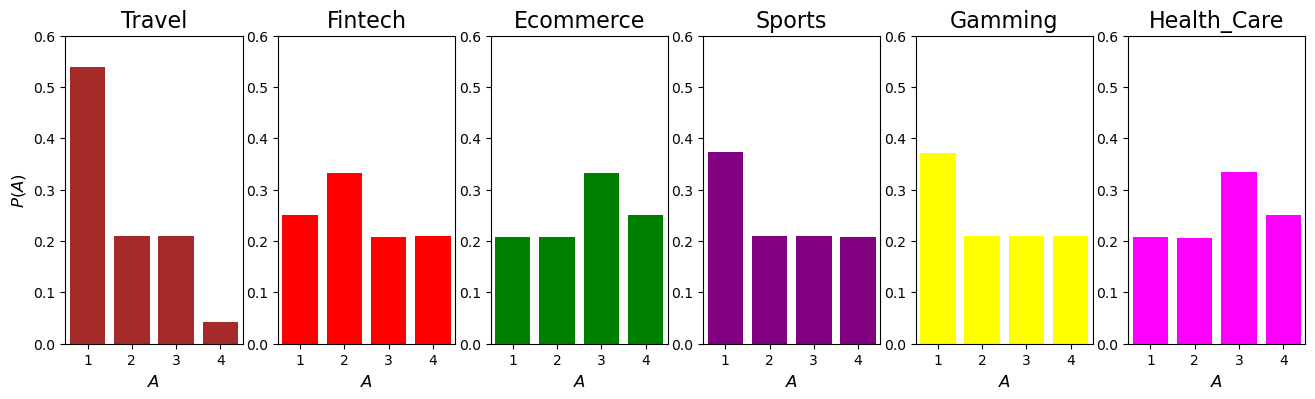

In [155]:
fig0, ax0 = plt.subplots(1,6, figsize=(16,4))
plt.rcParams['font.size'] = 10
Prob_A_plot(Prob_A,ax0,'travel','brown',0)
Prob_A_plot(Prob_A,ax0,'fintech','red',1)
Prob_A_plot(Prob_A,ax0,'ecommerce','green',2)
Prob_A_plot(Prob_A,ax0,'sports','purple',3)
Prob_A_plot(Prob_A,ax0,'gamming','yellow',4)
Prob_A_plot(Prob_A,ax0,'health_care','magenta',5)
plt.show()

<a id='P(A|E)'></a>
### Calculating and plotting $P(A|E)$

The values of $P(A|E)$ will depend on whether the editor skill equals the task domain, $S(E) = D$.
This piece of information is not known in our challenge. I will consider a skill boundary above which we assume the skill equals the task domain. If the editor's skill is higher than $3$, I consider the editor to have a skill above average, for $3$ is our middle number on our skill scale. For this reason, I consider that $S(E)=D$ if the editor's skill $S(E)$ is $4$ and above. 

$$S(E) < 4 \implies S(E) \neq D \implies P(A|E) = \frac{P(A)}{A}$$

$$S(E) \geqslant 4 \implies S(E)=D \implies P(A|E) = P(A) \beta_d A $$

where $\beta_d$ is the value of $\beta$ for domain $d$.

First, we need to calculate these $\beta_d$ values to be used when $S(E)=D$. We can calculate $\beta_d$ because $\sum_A P(A|E) = 1$ when $S(E)=D$.

For any domain $d$ we have:
$$\sum_A P(A|E) = 1 \Leftrightarrow P(1|E) + P(2|E) + P(3|E) + P(4|E) = 1 \Leftrightarrow $$
$$ \Leftrightarrow P(1) \beta_d \times 1 + P(2) \beta_d \times 2 + P(3) \beta_d \times 3 + P(4) \beta_d \times 4 = 1 \Leftrightarrow $$
$$ \Leftrightarrow \big( P(1) \times 1 + P(2) \times 2 + P(3) \times 3 + P(4) \times 4 \big) \beta_d = 1 \Leftrightarrow $$

$$ \Leftrightarrow \beta_d = \frac{1}{P(1) \times 1 + P(2) \times 2 + P(3) \times 3 + P(4) \times 4} $$

$$ \Leftrightarrow \beta_d = \frac{1}{P(1) + 2 P(2) + 3 P(3) + 4 P(4)} $$

In [156]:
Beta = {domain: 1/(Prob_A[domain][0]+2*Prob_A[domain][1]+3*Prob_A[domain][2]+4*Prob_A[domain][3]) for domain in domains}
Beta

{'health_care': 0.3806055087639426,
 'ecommerce': 0.38086560364464694,
 'fintech': 0.4208406745532343,
 'gamming': 0.44326617179215266,
 'sports': 0.4446808510638298,
 'travel': 0.5702592087312414}

Now that we have the values of $\beta_d$, we can calculate $P(A|E)$.

In [157]:
#By definition of beta_d, the 'D' values are already probabilities for they sum up to 1.
#The 'Not D' values, however, end up being weights and not probabilities because they do not sum to 1.
Prob_A_weights_given_E = {domain: {'D':list(map(lambda A: Prob_A[domain][A-1]*Beta[domain]*A,range(1,5))),
                           'Not D':list(map(lambda A: Prob_A[domain][A-1]/A,range(1,5)))} for domain in domains}

# Converting 'Not D' weights here to probabilities by dividing all weights by the weight sums for each domain.
Prob_A_given_E = {domain: {'D': Prob_A_weights_given_E[domain]['D'],
                           'Not D': list(map(lambda A: Prob_A_weights_given_E[domain]['Not D'][A-1]/sum(Prob_A_weights_given_E[domain]['Not D']),range(1,5)))}
                  for domain in domains}

The $P(A|E)$ plots show that when $S(E)=D$, the higher the quality interval, the higher the probability, but such probability profiles are not impressive. Therefore, if we are to assign tasks in order to avoid idle editors, we shall expect a relatively low task quality on average. 

In the travel domain, however, the probability of a highly skilled editor performing a task that belongs to the quality interval $4$ is quite low. This shows that our severe lack of translation editing skills in the travel domain may bring a lack of task quality that will affect this domain severely. 

Of course, when $S(E) \neq D$, we can only expect low quality tasks given that there is an astounding probability imbalance towards low quality intervals in all domains, which is also especially pronounced in the travel domain.

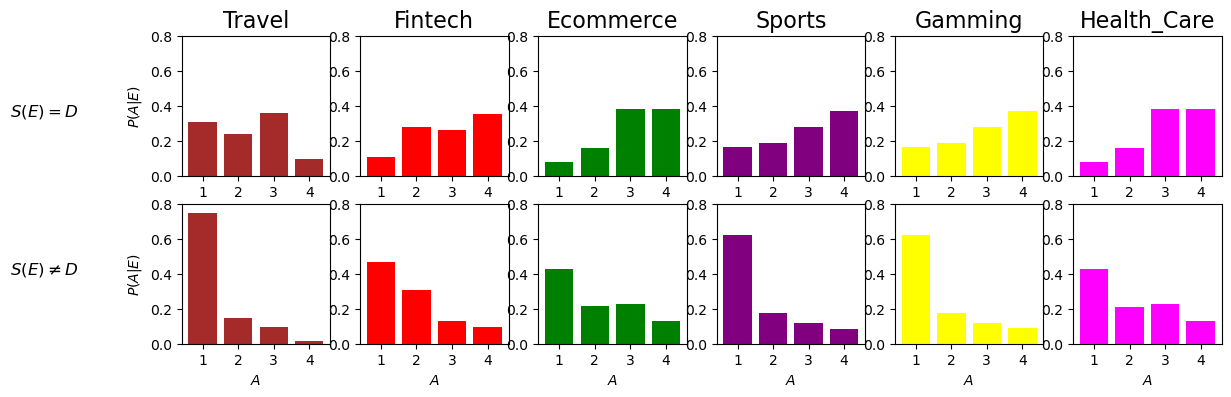

In [158]:
fig01, ax01 = plt.subplots(2,6, figsize=(16,4))
plt.rcParams['font.size'] = 9
plt.subplots_adjust(left=0.25)
plt.text(-29.5,1.3,r'$S(E)=D$',fontsize=12)
plt.text(-29.5,0.4,r'$S(E) \neq D$',fontsize=12)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'travel','brown',0)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'fintech','red',1)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'ecommerce','green',2)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'sports','purple',3)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'gamming','yellow',4)
Prob_A_given_E_plot(Prob_A_given_E,ax01,'health_care','magenta',5)
plt.show()

<a id='language_pairs'></a>
## Language pairs of the editors

Checking the language pairs of submitted tickets, we find we only have four different language pairs.

In [159]:
tasks_all['language_pair'].value_counts()

pt_en    33509
es_ja    16698
fr_de    16656
nl_en    16290
Name: language_pair, dtype: int64

Although we do not have access to the language pairs of the editors, $LP_e$. The simplest assumption to make here would be that  all editors are skilled in all language pairs, but that seems unrealistic. Instead, I will make two realistic assumptions:
- Each editor is only skillful in one language pair;
- The frequency of language pairs in the editors is the same as the frequency of language pairs in the tasks.

Therefore, I will assign a language pair to each editor using a stochastic sampling with a `language_pair_weights` vector that is brought up from the number of tasks we have in each language pair.

In [160]:
language_pairs = tasks_all['language_pair'].value_counts().index.to_list()
language_pair_weights = tasks_all['language_pair'].value_counts().to_list()

After sampling and assigning a language pair to each editor, these are the number of editors we ended up having for each language pair.

In [161]:
post_editors['language_pair'] = random.choices(language_pairs,weights=language_pair_weights,k=len(post_editors))
post_editors['language_pair'] .value_counts()

pt_en    155
nl_en     93
fr_de     92
es_ja     78
Name: language_pair, dtype: int64

<a id='initial_task_assignment'></a>
## Initial task assignment to the editors

I start by sorting the tasks by descending mean editor skill, so that the tasks belonging to the domain in which we have more skilled editors are allocated first. This sorting also guarantees that we take advantage of the most skillful editors to the best of our abilities. This sorting will penalize the travel sector, but in this sector we have a severe lack of skills anyway. This seems the best strategy to me because even though we have almost half of the tasks in the travel sector, if we prioritized this sector we would squander the time of the skill-$5$-editors we have on all other sectors in the travel sector instead, thereby sacrificing the quality of tasks in all other sectors while not increasing by much the quality of our travel sector tasks. 

To my eyes, this would be a disaster, because all other domains combined still give us the majority of the tasks and clients. On the other hand, because we have skilled editors to ensure a high translation quality in all other domains, we can get more tasks in these domains in the future and by then the travel domain will not be as prevalent.

In [162]:
#tasks_all.sort_values(by='domain',key=lambda x: tasks_all['domain'].value_counts()[x], ascending=False,inplace=True)
tasks_all.sort_values(by='domain',key=lambda x: skill_mean_by_domain[x], ascending=False,inplace=True)
tasks_all.reset_index(inplace=True,drop=True)
tasks_all

,id,number_words_ts,sequence_number,ticket_id,number_words_ti,tone,language_pair,quality_score,price,id_c,domain,category
0,7C6TA33NTSTRN55KN4EOIH4C1P1V34NC,40,21,C05770243,1896,informal,nl_en,-1,-1,6f053273db5aca5095bea082c7125096e5414d07e417cf...,health_care,Small
1,SZVT78WQMYPOLVRSPT04W1W3SZSB8DT2,40,20,C05768895,1009,formal,fr_de,-1,-1,08790ec4a07f4ea4f0aca6da75882c7bb044c29fe642b0...,health_care,Enterprise
2,R9IHD427UIWWBME1RS8ZRQY07LAO5752,31,3,C05768897,111,informal,pt_en,-1,-1,08790ec4a07f4ea4f0aca6da75882c7bb044c29fe642b0...,health_care,Enterprise
3,8FEC9PEIH641DW4ET2O9EVND4YYHFBQ4,40,2,C05768897,111,informal,pt_en,-1,-1,08790ec4a07f4ea4f0aca6da75882c7bb044c29fe642b0...,health_care,Enterprise
4,6OMA8G7KAJTLKVR7I7J7F5BFPECQGY11,40,1,C05768897,111,informal,pt_en,-1,-1,08790ec4a07f4ea4f0aca6da75882c7bb044c29fe642b0...,health_care,Enterprise
...,...,...,...,...,...,...,...,...,...,...,...,...
83148,T204ANX49WX5PVNF561R113OPZG49X62,40,9,C05766897,561,informal,es_ja,-1,-1,18ed578fb9a74e501b2cb547bd2ecd8d49c5a5e2aa6a19...,travel,Small
83149,WLZR8EZJUYCRHK9636XO3ZC92AMYCEGR,40,10,C05766897,561,informal,es_ja,-1,-1,18ed578fb9a74e501b2cb547bd2ecd8d49c5a5e2aa6a19...,travel,Small
83150,TLGYRUZLZ8QHS3QR9ROU53Z6XAOUPXVV,40,11,C05766897,561,informal,es_ja,-1,-1,18ed578fb9a74e501b2cb547bd2ecd8d49c5a5e2aa6a19...,travel,Small
83151,TG260PZ6DTFSOYG07PI1WPTK0M1D8HRV,40,12,C05766897,561,informal,es_ja,-1,-1,18ed578fb9a74e501b2cb547bd2ecd8d49c5a5e2aa6a19...,travel,Small


I am taking note on the `tasks_all` table which editor is assigned to each task and what skill this editor has to do this task. For that we need two extra columns, the `'editor_assigned'` and the `'editor_skill'` columns.

In [163]:
tasks_all['editor_assigned'] = [None] * len(tasks_all)
tasks_all['editor_skill'] = [0] * len(tasks_all)

Tasks will be stochastically assigned, according to a probability that will depend on the editor's skill in that domain.
Let $w(S(E))$ be the weight given to an editor $E$ of skill $S(E)$, we will have

$w(S(E))=\Bigg\{\genfrac{}{}{0}{0}{0}{10^{S(E)}} \genfrac{}{}{0}{0}{if \space \space S(E)=1}{if S(E) \geqslant 2}$

Skill-$5$-editor has a weight that is 10 times higher than a skill-$4$-editor, which has a 10-time-higher weight than a skill-$3$-editor, and so on. By assigning a weight of $0$ to skill-$1$-editors, I am assigning them no task.

In [164]:
editor_weights = post_editors.iloc[:,1:7].replace(to_replace=[1,2,3,4,5],value=[0,10**2,10**3,10**4,10**5])

Now let's assign the tasks by language pair and by domain.

In [165]:
for LP in language_pairs:
    for domain in domains:
        tasks_all.loc[(tasks_all['language_pair']==LP) & (tasks_all['domain']==domain),'editor_assigned'] = random.choices(
            post_editors.loc[post_editors['language_pair']==LP,'id'].to_list(),
            weights=editor_weights.loc[post_editors['language_pair']==LP,domain],
            k=len(tasks_all[(tasks_all['language_pair']==LP) & (tasks_all['domain']==domain)]))

Collecting the editors' skills to the tasks assigned.

In [166]:
t0=time.process_time()
editor_assigned_list = tasks_all['editor_assigned'].to_list()
domain_list = tasks_all['domain'].to_list()
editor_skills_list = [int(post_editors.loc[post_editors['id']==editor_assigned_list[i],domain_list[i]]) for i in range(0,len(editor_assigned_list))]
tasks_all['editor_skill'] = editor_skills_list
t1=time.process_time()
print('Editor skill for tasks assessed in',t1-t0,'seconds.')

Editor skill for tasks assessed in 58.15625 seconds.


Calculating task quality using the `quality` function.

In [167]:
editor_skill_list = tasks_all['editor_skill'].to_list()
domain_list = tasks_all['domain'].to_list()

quality_t0 = time.process_time()
tasks_all['quality_score'] = [quality(editor_skill_list[i], domain_list[i],Prob_A_given_E,post_editors) for i in range(0,len(editor_skill_list))]
print('Task quality assessed in',time.process_time()-quality_t0,'seconds.')

Task quality assessed in 1.734375 seconds.


Counting the number of tasks allocated to each editor.

In [168]:
number_tasks_allocated = pd.DataFrame(tasks_all['editor_assigned'].value_counts())
number_tasks_allocated.head()

,editor_assigned
10736c1b4ed42796f3fc934b12d5c2a1f1c02d411c6f1375950b276c12c77579,979
dcc7fc84bd4373ebddbc712d341f39188b38ce989ebf3341f035ce2aebd1b5a7,879
c9b0ede933d63cb229624364de826249cab62d9bef270c1b5c71615a3549f54f,857
0e67693edce2a28cf513aa42540761f7dae661460542e369e327539c8bed5a0a,833
2c0108ee6a2c8a1ec31eaa676f030b2eb8a9ebe03b2564630eb9290d9e39853e,825


We can see here that the editor having more tasks has $979$ tasks assigned, which is less than the maximum of $1125$ tasks we should allocate in order to deliver all tasks on time to the client that has requested the least amount of tasks to the company.

This means we will ensure the tasks are translated way within the deadlines to which the company has publicly committed to all clients.

In [169]:
post_editors['tasks_allocated'] = [number_tasks_allocated.at[editor,'editor_assigned'] if editor in number_tasks_allocated.index else 0 for editor in post_editors['id']]

Let's see how many idle editors we have $-$ editors to which no task was assigned.

In [170]:
post_editors[post_editors['tasks_allocated']==0]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated
270,7d373d3809c88b4ca0cfe2fbf5a5f935e0d564cf98ae3b...,1,1,1,1,1,2,fr_de,0
273,19284b6dd552469e5d5b59869de29976e54a746eaddeb4...,1,1,1,1,3,3,nl_en,0
295,18c6c263c7824e254d665831f42f00110a6179ba97377b...,1,3,1,3,1,1,es_ja,0
302,53fa4cf1956c1eda52267e6e02cd58e84cd7ab7ff07646...,1,2,1,1,1,2,pt_en,0


We have only $4$ idle editors, which have low skills has expected, even though they have skill $3$ in some domains. This is still a sharp reduction in terms of idle editors when compared to the $\textit{"large group of editors"}$ that were complaining to be idle before.
On the other hand, we have $156$ editors that have less than $62$ tasks, the number of tasks expected to be performed in one week. Some of these editors have skill $4$ in some domains, so we shall definitely count more on their services.

In [171]:
post_editors[post_editors['tasks_allocated']<62]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated
0,dd2a4a379c04b944834c66cc797815f0f6b01c10858e8b...,2,4,4,2,5,3,fr_de,59
6,d75edf7bf3c340b56e8255f968b37576739bfc29914202...,1,1,3,4,3,3,pt_en,7
7,5379170989104e67c71efdba8d57bacb48c04ef350d91b...,3,2,2,2,1,3,fr_de,45
17,c1362802f35ff23bfcdf2ed37017c1be122c247fd8a6ac...,3,3,2,3,1,1,nl_en,51
24,23174ccee5dc5eb5890c33847903a3f3adadca3883d803...,2,2,4,3,1,4,nl_en,28
...,...,...,...,...,...,...,...,...,...
413,7a3bfb44ceb840fb01e49b03968396965cc51ad37f16ae...,1,2,2,1,1,4,fr_de,8
414,8ed50fc26c49d98c19987a11213aad4c5ef52c53122199...,1,2,4,1,1,4,pt_en,22
415,78ff5107579690a5982b2df3439111b985e2175a127db6...,1,2,4,1,1,4,nl_en,30
416,80503580365a55d01da92e418a5cac75a3c8450ebc1655...,1,2,4,1,1,4,nl_en,30


Still, this first task assignment has achieved good results. As expected by the weights we have used for task assignment, the overwhelming majority of the tasks were allocated to skill-$4$ and skill-$5$-editors, which gives a guarantee of quality, for I am assuming that editor skill assessment has been based on previous task quality assessed over several previous tasks taken by the editors in the past.

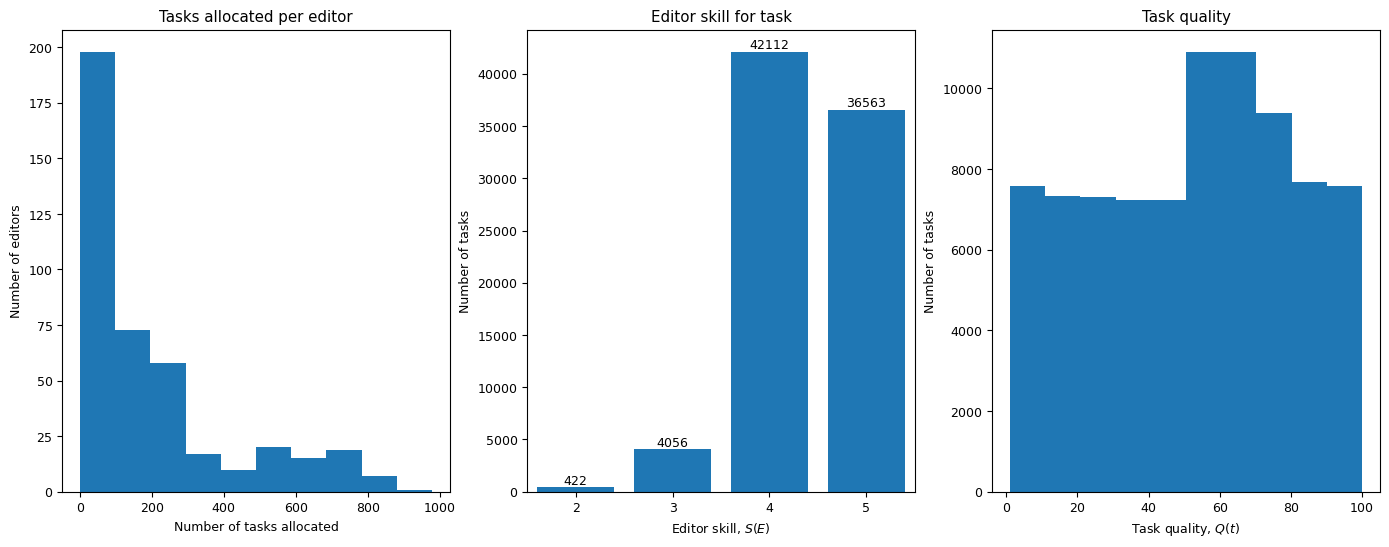

In [172]:
first_assignment_plots(post_editors,tasks_all)

As a predicted consequence, mean task quality obtained is above $50$, which is also a good indication.

In [173]:
mean_quality = [tasks_all['quality_score'].mean()]
mean_quality

[52.10979760201075]

We see though some heterogeneity in task quality among task domains, with the travel domain having the lowest quality, as expected.

In [174]:
mean_quality_by_domain = tasks_all.groupby('domain')['quality_score'].mean().sort_values(ascending=False)
mean_quality_by_domain

domain
ecommerce      64.449055
health_care    64.343819
fintech        59.280373
gamming        59.106687
sports         58.160276
travel         41.733002
Name: quality_score, dtype: float64

Quality variation is relatively high, especially when we take into account the mean task quality values.

In [175]:
stdev_quality = [tasks_all['quality_score'].std()]
stdev_quality

[27.827647709658393]

The mean skill is high, way higher than $4$. This is a good sign, it is the metric we can control the best. Variation in skill is significant also, though.

In [176]:
mean_skill = [tasks_all['editor_skill'].mean()]
mean_skill

[4.380780007937176]

In [177]:
stdev_skill = [tasks_all['editor_skill'].std()]
stdev_skill

[0.6031550143517039]

The pattern of task assignment among task domains is similar to the one observed over all domains altogether. Naturally, we have no tasks assigned to skill-$5$-editors in the travel sector... again, we wish we had such editors.

<a id='Initial_task_assignment_by_domain'></a>

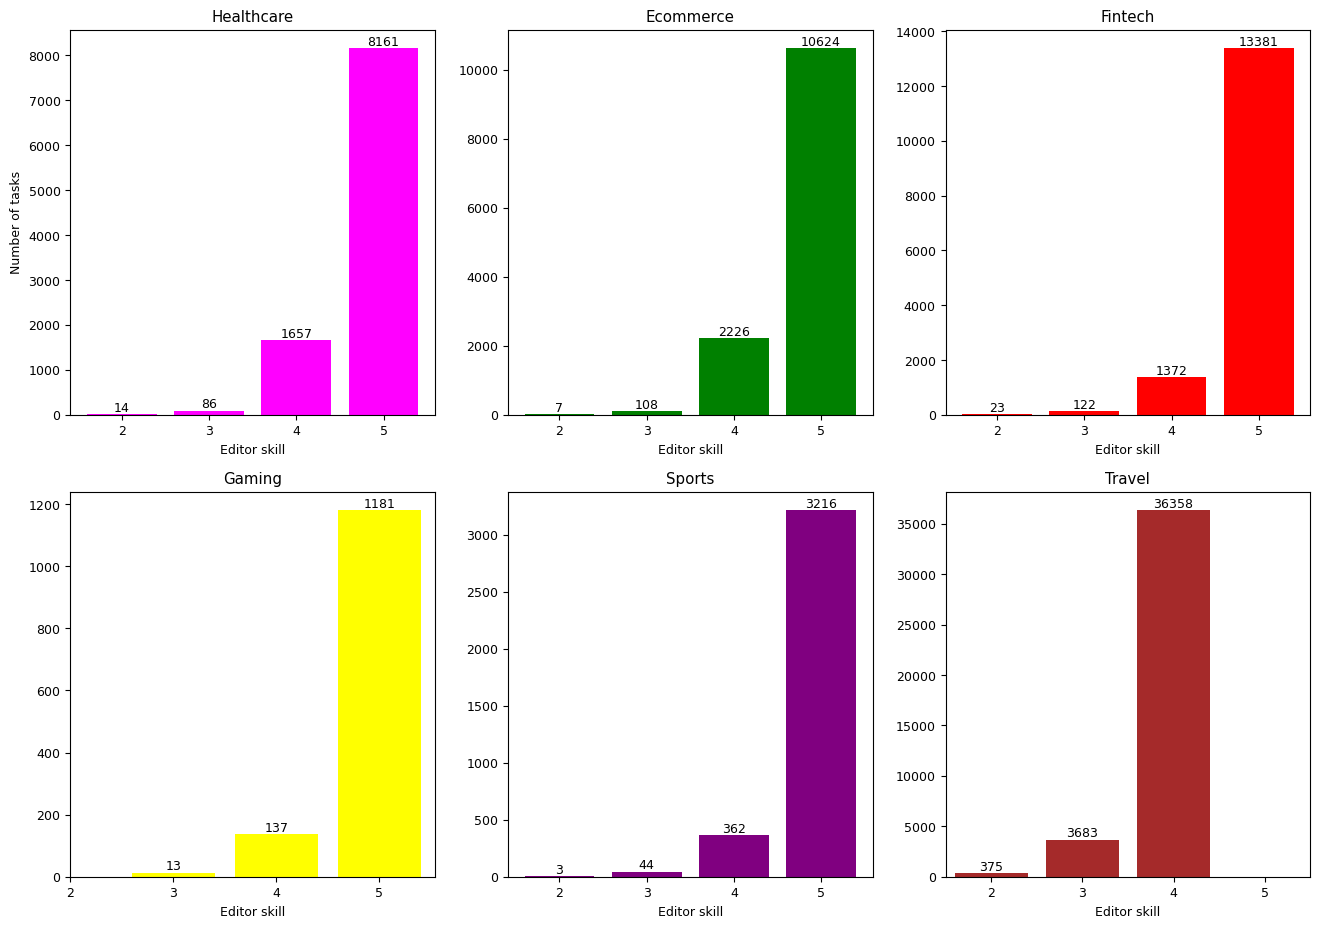

In [178]:
assignment_by_domain_plots(tasks_all)

This first task assignment was quite good overall:
1. It has brought high quality to all domains apart from the travel domain;
2. It brought the best quality we could have in the travel sector tasks given our lack of travel domain editor skills;
3. It has mostly avoided the issue of idle editors, remaining only $3$ low-skilled editors without tasks;
4. It allows our editors to meet Unbabel's deadlines.

We can still optimize this assignment to increase task quality further while distributing the tasks more evenly. We see that among the $155$ editors with less than the weekly load of $62$ tasks, we have high-skilled editors whose skills we can still use better, so we can deliver high-quality tasks quicker to the clients.

<a id='simulated_annealing'></a>
## Optimizing task assignments

I opted to design an algorithm inspired on the Simulated Annealing algorithm to optimize task assignment because we actually do not have a defined function to optimize. We would like to maximize task quality and minimize the number of idle editors, but we do not have a function that can relate these with the profile of editor skills we have.

In this algorithm, we have the possibility of going farther away from our optimal solution, so that we ensure we can reach a global optimal solution instead of remaining stuck in a local optimal solution.

We will try here to maximize an objective function $E$ defined below:

$$E = (1-10^{-6}) \space \frac{{\bar{s}}_{new}}{\bar{s}_{old}}+10^{-6} \space t_{min} $$

where $\bar{s}$ is the overall task skill mean before ($old$) and after task reassignment ($new$), whereas $t_{min}$ is the minimum amount of tasks assigned per editor. Basically, we want to increase task skill on average and reduce the number of idle editors by allocating more tasks to the less busy editors if possible.

In the procedure I devised here, I will first randomly sample 2 editors from each language pair. One of these editors is more in demand $-$ having more than $300$ tasks assigned $-$ and the other is less in demand $-$ having less than the expected weekly load of $62$ tasks assigned. In each optimization cycle $T$, I will randomly select a task which was previously assigned to the editor more in demand and reassign it to the editor less in demand. I will assess the skill of this editor for this reassigned task and one of two alternatives can occur:
- The skill of the new editor (less in demand) is higher or equal to the skill of the previous editor (more in demand): then this reassignment is approved and we surely have an improvement in task distribution while we are sure we do not sacrifice on task skill $-$ we can even improve skill as well;
- The skill of the new editor is lower than the skill of the previous editor: then we only accept this reassignment according an Acceptance Criterion; here I will only accept this reassignment if $$X \leqslant e^{\tfrac{-5 \times 10^5 \space (E_{old} - E_{new})}{300/T}}$$
where $X$ is a randomly variable sampled from a Uniform $[0,1]$ distribution, $T$ is a natural number representing the optimization cycle and $E$ our objective function before ($old$) and after task reassignment ($new$). The constants in this criterion were calculated so that this threshold value decreased to near-zero values after 2500 cycles, so that the global optimum search does not extend far beyond that number of optimization cycles.

For a typical difference in the evaluation function $E_{old}-E_{new}$ of $10^{-6}$, we can see how this threshold value changes along the optimization cycles. Note that this Acceptance Criterion is also known as the Metropolis Criterion.

(0.0, 1.0)

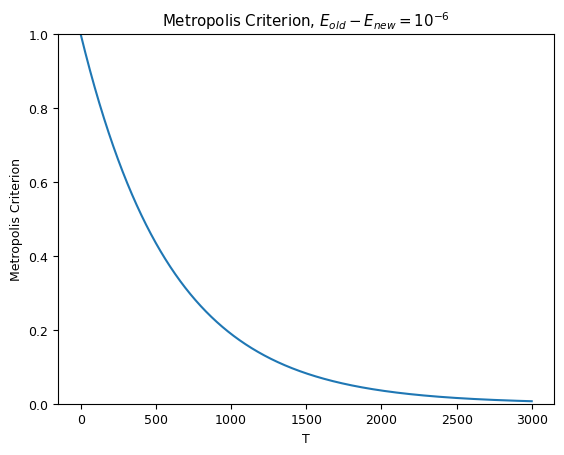

In [179]:
TestT = list(range(1,3000))
E_diff = 1e-6
TestMetropolis = list(map(lambda T: np.exp(-5e5*E_diff/(300/T)),TestT))
metropolis_criterion_df = pd.DataFrame({'T':TestT,'Metropolis':TestMetropolis})
metropolis_criterion_df.plot('T','Metropolis', legend=False)
plt.title('Metropolis Criterion, $E_{old}-E_{new} = 10^{-6}$')
plt.ylabel('Metropolis Criterion')
plt.ylim(0,1)

Now let's define our optimization algorithm in the `task_optimization_thr` function.

In [180]:
def task_optimization_thr(post_editors_table,tasks_table,Prob_A_given_E,LP,mean_quality,mean_skill,stdev_quality,stdev_skill,minimum_editor_tasks,assignment_evaluation,T_evaluations,number_task_swaps=20000,stringent=False):
    global T
    
    random.seed(44)
    vectors_lock = threading.Lock()
    T_lp = 0
    while T_lp <=number_task_swaps:
        
        T += 1
        Te = T
        T_lp += 1
        
        more_demanded_editor = post_editors_table[(post_editors_table['language_pair']==LP) & (post_editors_table['tasks_allocated']>300)].sample(n=1,weights='sampling_weights')
        sampled_task = tasks_table[tasks_table['editor_assigned'].isin(more_demanded_editor['id'])].sample(n=1)

        if Te % 1000 == 0:
            print('Optimization in progress:','LP =',LP,', T =',Te,
              '| Mean quality =',"{0:.5f}".format(mean_quality[-1]),
              '| Mean skill =',"{0:.5f}".format(mean_skill[-1]),
              '| Minimum editor tasks =',minimum_editor_tasks[-1])
        
        if int(sampled_task['editor_skill'])==5:
            continue
        
        less_demanded_editor = post_editors_table[(post_editors_table['language_pair']==LP) & (post_editors_table['tasks_allocated']<62)].sample(n=1,weights='sampling_weights')
        sampled_task['new_editor'] = less_demanded_editor.iat[0,0]
        sampled_task['new_editor_skill'] = editor_skill_for_task(sampled_task,post_editors_table, optimizing=True)
        
        if int(sampled_task['new_editor_skill'])==1:
            continue
            
        sampled_task['quality_score'] = quality(sampled_task['new_editor_skill'].iloc[0],
                                                sampled_task['domain'].iloc[0],
                                                Prob_A_given_E, 
                                                post_editors_table)
        new_mean_skill = float((tasks_table['editor_skill'].sum()-
                                sampled_task['editor_skill']+sampled_task['new_editor_skill'])/len(tasks_table))
        new_stdev_skill = float(tasks_table['editor_skill'].agg(lambda skill: np.sqrt((sum((skill-new_mean_skill)**2)-
                        (sampled_task['editor_skill']-new_mean_skill)**2+
                        (sampled_task['new_editor_skill']-new_mean_skill)**2)/(len(tasks_table)-1))))
        new_minimum_time = min(post_editors_table['tasks_allocated'].min(),less_demanded_editor['tasks_allocated'].iloc[0])
        new_evaluation = objective_function(new_mean_skill,mean_skill[0],new_minimum_time)
    
        
        if int(sampled_task['new_editor_skill']) < int(sampled_task['editor_skill']):
            if stringent:
                continue
            else:
                metropolis_probability = metropolis(new_evaluation,assignment_evaluation[-1],Te)
                if random.random() > metropolis_probability:
                    continue
        
        tasks_table.at[sampled_task.index[0],'quality_score'] = sampled_task['quality_score']
        tasks_table.at[sampled_task.index[0],'editor_assigned'] = sampled_task['new_editor'].iloc[0]
        tasks_table.at[sampled_task.index[0],'editor_skill'] = sampled_task['new_editor_skill']
    
        post_editors_table.loc[post_editors_table['id']==more_demanded_editor['id'].to_list()[0],'tasks_allocated'] -=1 
        post_editors_table.loc[post_editors_table['id']==less_demanded_editor['id'].to_list()[0],'tasks_allocated'] +=1
        
        vectors_lock.acquire()
        mean_quality.append(tasks_table['quality_score'].mean())
        stdev_quality.append(tasks_table['quality_score'].std())
        minimum_editor_tasks.append(post_editors_table['tasks_allocated'].min())
        mean_skill.append(new_mean_skill)
        stdev_skill.append(new_stdev_skill)
        assignment_evaluation.append(new_evaluation)
        T_evaluations.append(Te)
        vectors_lock.release()
        #print('Last:',new_mean_skill,'First:',mean_skill[0],'Minimum tasks:',new_minimum_time,'Evaluation:',assignment_evaluation[-1])

I will run the algorithm using 4 threads, one per language pair.

In [181]:
post_editors_optimized_table_thr = post_editors.copy()
tasks_all_optimized_table_thr = tasks_all.copy()
#post_editors_optimized_table_thr['sampling_weights'] = abs(post_editors_optimized_table_thr['tasks_allocated']-post_editors_optimized_table_thr['tasks_allocated'].mean())

#I have arbitrarily defined 500 tasks as an ideal number of tasks to assign to a given editor. 
#Using these weights, the higher the difference to these 500 tasks assigned, the higher the weight.
post_editors_optimized_table_thr['sampling_weights'] = abs(post_editors_optimized_table_thr['tasks_allocated']-500)

T = 0
mean_quality_thr = [tasks_all['quality_score'].mean()]
mean_skill_thr = [tasks_all['editor_skill'].mean()]
stdev_quality_thr = [tasks_all['quality_score'].std()]
stdev_skill_thr = [tasks_all['editor_skill'].std()]
minimum_editor_tasks_thr = [post_editors['tasks_allocated'].min()]
assignment_evaluation_thr = [objective_function(mean_skill_thr[0],mean_skill_thr,minimum_editor_tasks_thr[0])]
T_evaluations_thr = [0]

In [182]:
if __name__=='__main__':
    Thread1 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_thr,tasks_all_optimized_table_thr,Prob_A_given_E,'pt_en',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000))
    Thread2 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_thr,tasks_all_optimized_table_thr,Prob_A_given_E,'es_ja',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000))
    Thread3 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_thr,tasks_all_optimized_table_thr,Prob_A_given_E,'fr_de',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000))
    Thread4 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_thr,tasks_all_optimized_table_thr,Prob_A_given_E,'nl_en',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000))
    
    thread_start = time.perf_counter()
    Thread1.start()
    Thread2.start()
    Thread3.start()
    Thread4.start()
    
    Thread1.join()
    Thread2.join()
    Thread3.join()
    Thread4.join()
    thread_time = time.perf_counter() - thread_start
    print('Elapsed Time: {:.2f} seconds'.format(thread_time))

Optimization in progress: LP = es_ja , T = 1000 | Mean quality = 52.10619 | Mean skill = 4.38059 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 2000 | Mean quality = 52.10758 | Mean skill = 4.38061 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 3000 | Mean quality = 52.10828 | Mean skill = 4.38061 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 4000 | Mean quality = 52.10908 | Mean skill = 4.38062 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 5000 | Mean quality = 52.10975 | Mean skill = 4.38064 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 6000 | Mean quality = 52.11012 | Mean skill = 4.38065 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 7000 | Mean quality = 52.11022 | Mean skill = 4.38066 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 8000 | Mean quality = 52.11034 | Mean skill = 4.38066 | Minimum editor tasks = 0
Optimiza

Optimization in progress: LP = es_ja , T = 67000 | Mean quality = 52.11066 | Mean skill = 4.38092 | Minimum editor tasks = 0
Optimization in progress: LP = es_ja , T = 68000 | Mean quality = 52.11077 | Mean skill = 4.38092 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 69000 | Mean quality = 52.11072 | Mean skill = 4.38094 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 70000 | Mean quality = 52.11021 | Mean skill = 4.38094 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 71000 | Mean quality = 52.10982 | Mean skill = 4.38094 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 72000 | Mean quality = 52.10979 | Mean skill = 4.38096 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 73000 | Mean quality = 52.10994 | Mean skill = 4.38096 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 74000 | Mean quality = 52.11015 | Mean skill = 4.38097 | Minimum editor tasks = 0


In [183]:
evaluation_thr_df = pd.DataFrame({'T':T_evaluations_thr, 'Minimum allocated tasks':minimum_editor_tasks_thr,
                              'Mean skill': mean_skill_thr, 'Mean quality': mean_quality_thr,
                              'Skill STDEV': stdev_skill_thr, 'Quality STDEV': stdev_quality_thr, 'Evaluation': assignment_evaluation_thr})

After the optimization process, we can consistently observe, as expected, the first period of global optimum search, in which we accept worse evaluations $-$ task skill declines on average while we do not avoid idle editors. Only after this global search ends $-$ because by cycle 2500 our Metropolis Criterion value becomes very close to zero $-$, the evaluation function starts increasing steadily, but we see that such increase never compensates the sharp initial decrease. The consequences are visible in our most significant metric: mean task skill remains lower than its initial value. On top of this, we also never get to assign tasks to all our idle editors. Interestingly, however, task quality has actually increased, which probably means that task mean skill loss was not that signficant after all.

This observation probably means that this initial search does more harm than good. There probably is a single optimum in our landscape and the initial global search only brings us farther away from that optimum and the following optimization cycles were not even enough to reverse the dynamics brought up by that initial search, let alone to improve our significant metrics. This shall be why our optimization had worsened our initial task assignment in terms of editor skill, even if slightly.

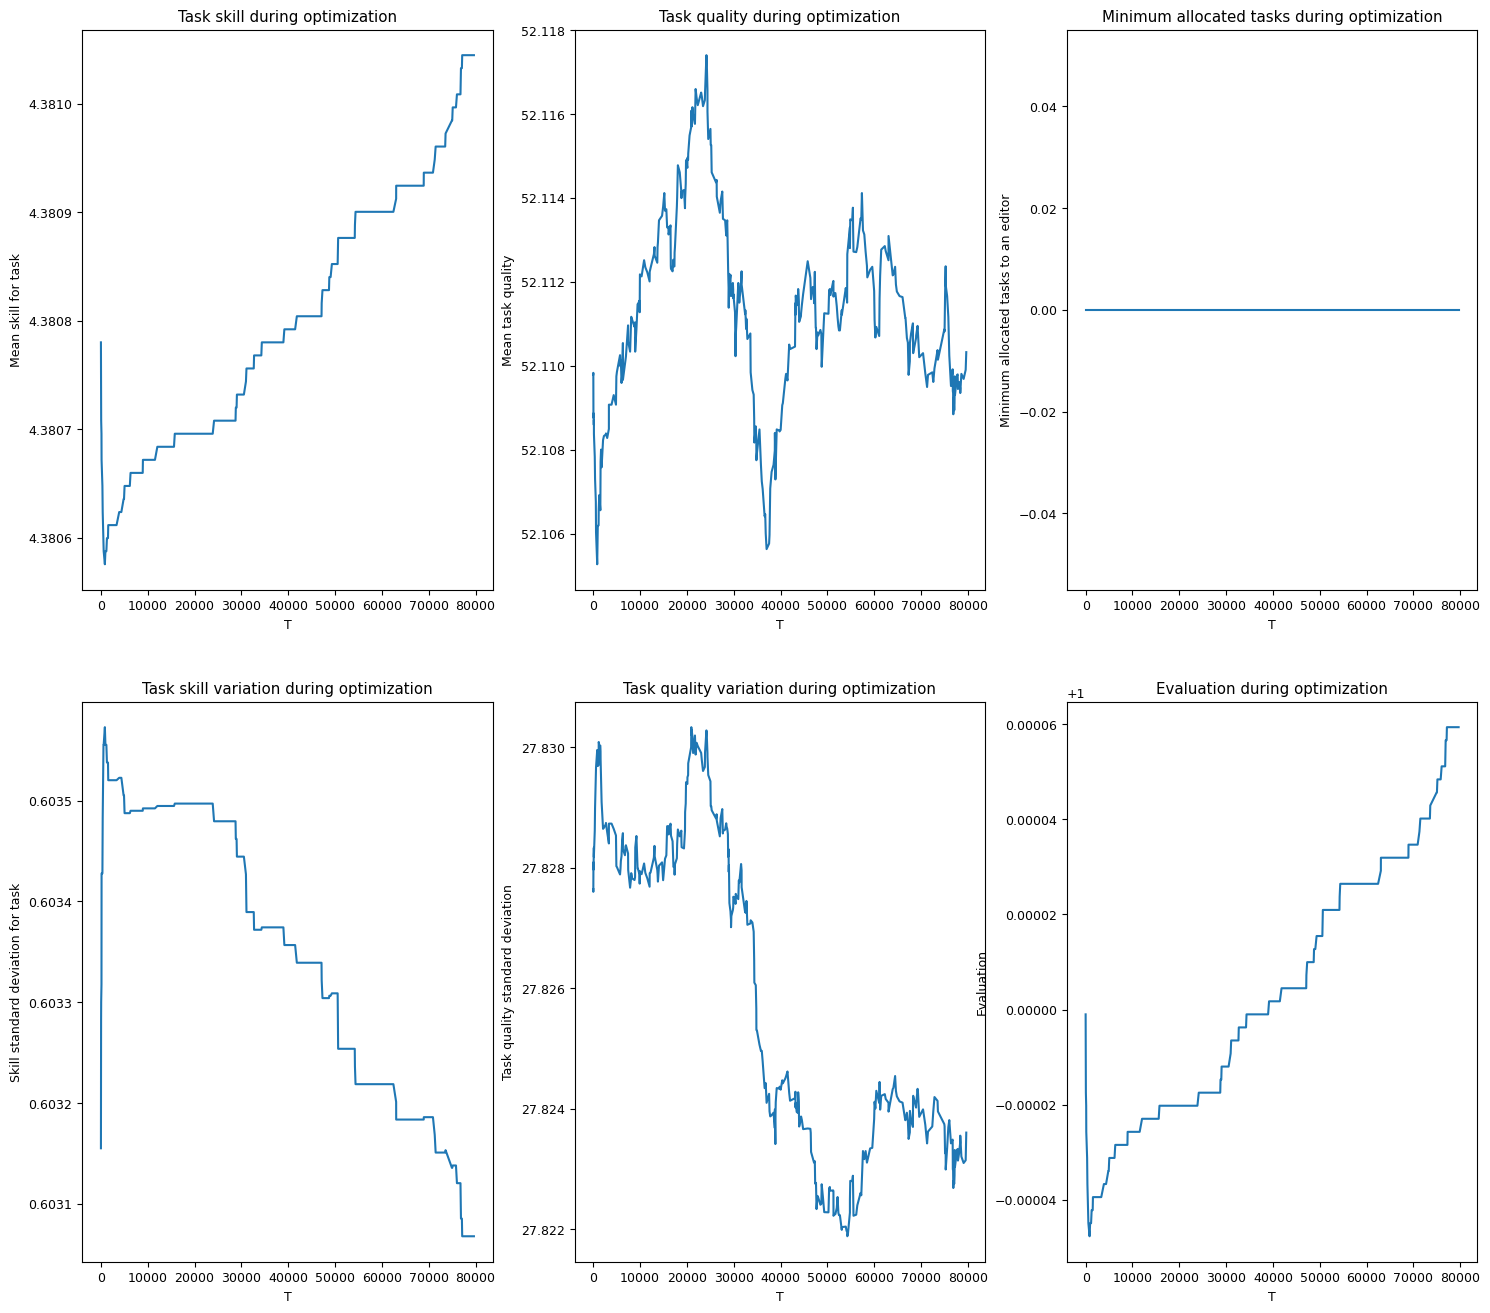

In [184]:
optimization_plots(evaluation_thr_df)

As an expected consequence of the slight decline in the average task skill compared to the initial stage, we also see that the optimization has decreased task quality in the sports and travel domains, which comprise $53.0\%$ of the tasks. Yet, this optimization has brought a slight increase in task quality in all other domains.

In [185]:
mean_quality_by_domain_after_optimization = tasks_all_optimized_table_thr.groupby('domain')['quality_score'].mean().sort_values(ascending=False)

mean_quality_comparison = pd.concat([mean_quality_by_domain,mean_quality_by_domain_after_optimization],axis=1,keys=['Before Optimization','After Optimization'])
mean_quality_comparison

,Before Optimization,After Optimization
domain,,
ecommerce,64.449055,64.454917
health_care,64.343819,64.346038
fintech,59.280373,59.300309
gamming,59.106687,59.124718
sports,58.160276,58.086345
travel,41.733002,41.730354


We are still left with the same $4$ idle editors.

In [186]:
post_editors_optimized_table_thr[post_editors_optimized_table_thr['tasks_allocated']==0]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated,sampling_weights
270,7d373d3809c88b4ca0cfe2fbf5a5f935e0d564cf98ae3b...,1,1,1,1,1,2,fr_de,0,500
273,19284b6dd552469e5d5b59869de29976e54a746eaddeb4...,1,1,1,1,3,3,nl_en,0,500
295,18c6c263c7824e254d665831f42f00110a6179ba97377b...,1,3,1,3,1,1,es_ja,0,500
302,53fa4cf1956c1eda52267e6e02cd58e84cd7ab7ff07646...,1,2,1,1,1,2,pt_en,0,500


In [187]:
post_editors_optimized_table_thr[post_editors_optimized_table_thr['tasks_allocated']<62]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated,sampling_weights
0,dd2a4a379c04b944834c66cc797815f0f6b01c10858e8b...,2,4,4,2,5,3,fr_de,61,441
6,d75edf7bf3c340b56e8255f968b37576739bfc29914202...,1,1,3,4,3,3,pt_en,8,493
7,5379170989104e67c71efdba8d57bacb48c04ef350d91b...,3,2,2,2,1,3,fr_de,45,455
17,c1362802f35ff23bfcdf2ed37017c1be122c247fd8a6ac...,3,3,2,3,1,1,nl_en,52,449
24,23174ccee5dc5eb5890c33847903a3f3adadca3883d803...,2,2,4,3,1,4,nl_en,32,472
...,...,...,...,...,...,...,...,...,...,...
413,7a3bfb44ceb840fb01e49b03968396965cc51ad37f16ae...,1,2,2,1,1,4,fr_de,10,492
414,8ed50fc26c49d98c19987a11213aad4c5ef52c53122199...,1,2,4,1,1,4,pt_en,24,478
415,78ff5107579690a5982b2df3439111b985e2175a127db6...,1,2,4,1,1,4,nl_en,34,470
416,80503580365a55d01da92e418a5cac75a3c8450ebc1655...,1,2,4,1,1,4,nl_en,36,470


Although we have reduced the number of editors with less than $62$ tasks from $156$ to $153$. We will remain with all these editors with few tasks, but keep in mind that there is a reason why less tasks have been assigned to these editors in the first place: they have lower skills.

Here is the task distribution according to domain and editor skill after optimization.

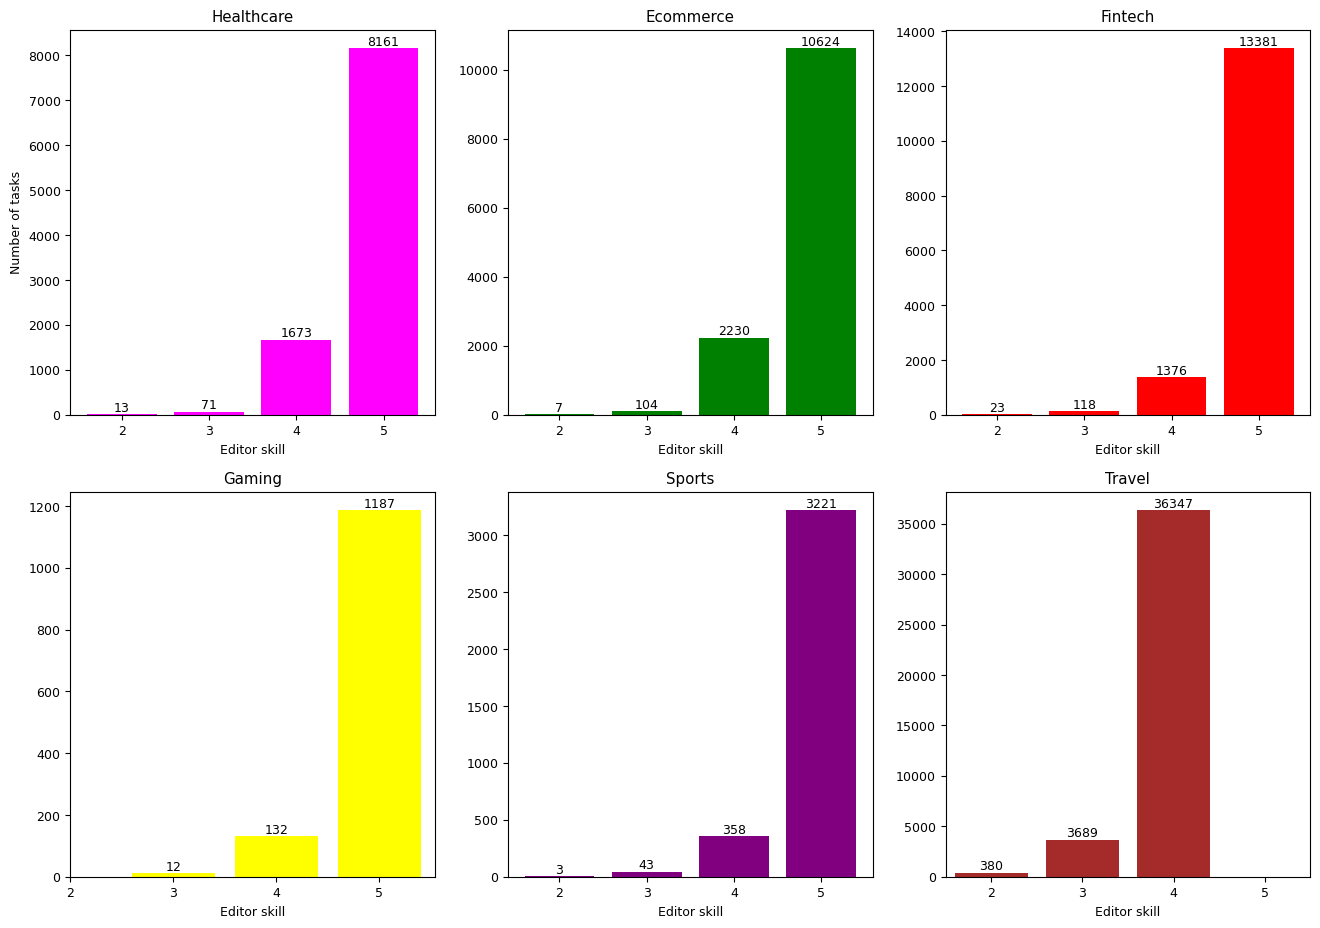

In [188]:
assignment_by_domain_plots(tasks_all_optimized_table_thr)

The table below allows us to compare these values with those we had before optimization. We see a transfer of dozens of tasks in the travel domain to the lower-skill editors, which probably justifies the decrease in average skill overall.

In [215]:
task_assignment_skill = pd.DataFrame({'Before optimization':tasks_all.groupby('domain')['editor_skill'].value_counts().sort_index().values,
                                            'After simulated annealing':tasks_all_optimized_table_thr.groupby('domain')['editor_skill'].value_counts().sort_index().values},
                                           index=tasks_all_optimized_table_thr.groupby('domain')['editor_skill'].value_counts().sort_index().index)
task_assignment_skill

Before optimization  After simulated annealing
domain      editor_skill                                                
ecommerce   2                               7                          7
            3                             108                        104
            4                            2226                       2230
            5                           10624                      10624
fintech     2                              23                         23
            3                             122                        118
            4                            1372                       1376
            5                           13381                      13381
gamming     3                              13                         12
            4                             137                        132
            5                            1181                       1187
health_care 2                              14                         13
            3                              86                         71
            4                            1657                       1673
            5                            8161                       8161
sports      2                               3                          3
            3                              44                         43
            4                             362                        358
            5                            3216                       3221
travel      2                             375                        380
            3                            3683                       3689
            4                           36358                      36347

<a id='stringent'></a>
### Stringent optimization

I have therefore decided to follow a stringent approach, in which we only accept a task reassignment if the evaluation function increases or remains the same. There will be no circumstance in which we accept a task reassignment that decreases the objective evaluation. The Metropolis Criterion will no longer apply. This approach shall take us to an overall skill level that is higher than the initial one.

In [190]:
post_editors_optimized_table_strthr = post_editors.copy()
tasks_all_optimized_table_strthr = tasks_all.copy()

post_editors_optimized_table_strthr['sampling_weights'] = abs(post_editors_optimized_table_thr['tasks_allocated']-500)

T = 0
mean_quality_thr = [tasks_all['quality_score'].mean()]
mean_skill_thr = [tasks_all['editor_skill'].mean()]
stdev_quality_thr = [tasks_all['quality_score'].std()]
stdev_skill_thr = [tasks_all['editor_skill'].std()]
minimum_editor_tasks_thr = [post_editors['tasks_allocated'].min()]
assignment_evaluation_thr = [objective_function(mean_skill_thr[0],mean_skill_thr,minimum_editor_tasks_thr[0])]
T_evaluations_thr = [0]

In [191]:
if __name__=='__main__':
    Thread1 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_strthr,tasks_all_optimized_table_strthr,Prob_A_given_E,'pt_en',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000,True))
    Thread2 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_strthr,tasks_all_optimized_table_strthr,Prob_A_given_E,'es_ja',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000,True))
    Thread3 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_strthr,tasks_all_optimized_table_strthr,Prob_A_given_E,'fr_de',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000,True))
    Thread4 = threading.Thread(target=task_optimization_thr, args=(post_editors_optimized_table_strthr,tasks_all_optimized_table_strthr,Prob_A_given_E,'nl_en',mean_quality_thr,mean_skill_thr,stdev_quality_thr,stdev_skill_thr,minimum_editor_tasks_thr,assignment_evaluation_thr,T_evaluations_thr,20000,True))
    
    thread_start = time.perf_counter()
    Thread1.start()
    Thread2.start()
    Thread3.start()
    Thread4.start()
    
    Thread1.join()
    Thread2.join()
    Thread3.join()
    Thread4.join()
    thread_time = time.perf_counter() - thread_start
    print('Elapsed Time: {:.2f} seconds'.format(thread_time))

Optimization in progress: LP = nl_en , T = 1000 | Mean quality = 52.11160 | Mean skill = 4.38078 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 2000 | Mean quality = 52.11357 | Mean skill = 4.38079 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 3000 | Mean quality = 52.11292 | Mean skill = 4.38079 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 4000 | Mean quality = 52.11292 | Mean skill = 4.38079 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 5000 | Mean quality = 52.11486 | Mean skill = 4.38082 | Minimum editor tasks = 0
Optimization in progress: LP = es_ja , T = 6000 | Mean quality = 52.11638 | Mean skill = 4.38082 | Minimum editor tasks = 0
Optimization in progress: LP = es_ja , T = 7000 | Mean quality = 52.11647 | Mean skill = 4.38082 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 8000 | Mean quality = 52.11568 | Mean skill = 4.38082 | Minimum editor tasks = 0
Optimiza

Optimization in progress: LP = fr_de , T = 67000 | Mean quality = 52.11847 | Mean skill = 4.38119 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 68000 | Mean quality = 52.11747 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = es_ja , T = 69000 | Mean quality = 52.11690 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 70000 | Mean quality = 52.11737 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 71000 | Mean quality = 52.11901 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = pt_en , T = 72000 | Mean quality = 52.11812 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = fr_de , T = 73000 | Mean quality = 52.11836 | Mean skill = 4.38120 | Minimum editor tasks = 0
Optimization in progress: LP = nl_en , T = 74000 | Mean quality = 52.11614 | Mean skill = 4.38120 | Minimum editor tasks = 0


In [192]:
evaluation_thr_stringent_df = pd.DataFrame({'T':T_evaluations_thr, 'Minimum allocated tasks':minimum_editor_tasks_thr,
                              'Mean skill': mean_skill_thr, 'Mean quality': mean_quality_thr,
                              'Skill STDEV': stdev_skill_thr, 'Quality STDEV': stdev_quality_thr, 'Evaluation': assignment_evaluation_thr})

As expected, under this stringent optimization, we can see a continuous increase in the mean task skill, alongside the continuous increase in the values of the objective evaluation function. This time, both the evaluation function and mean task skill were higher in the end than they were in the initial assignment, so we have clearly achieved a better solution in terms of quality and task distribution.

With the increase in task mean came an increase in task quality and a decrease both task skill variation and task quality variation (albeit with an increasing trend, it seems).

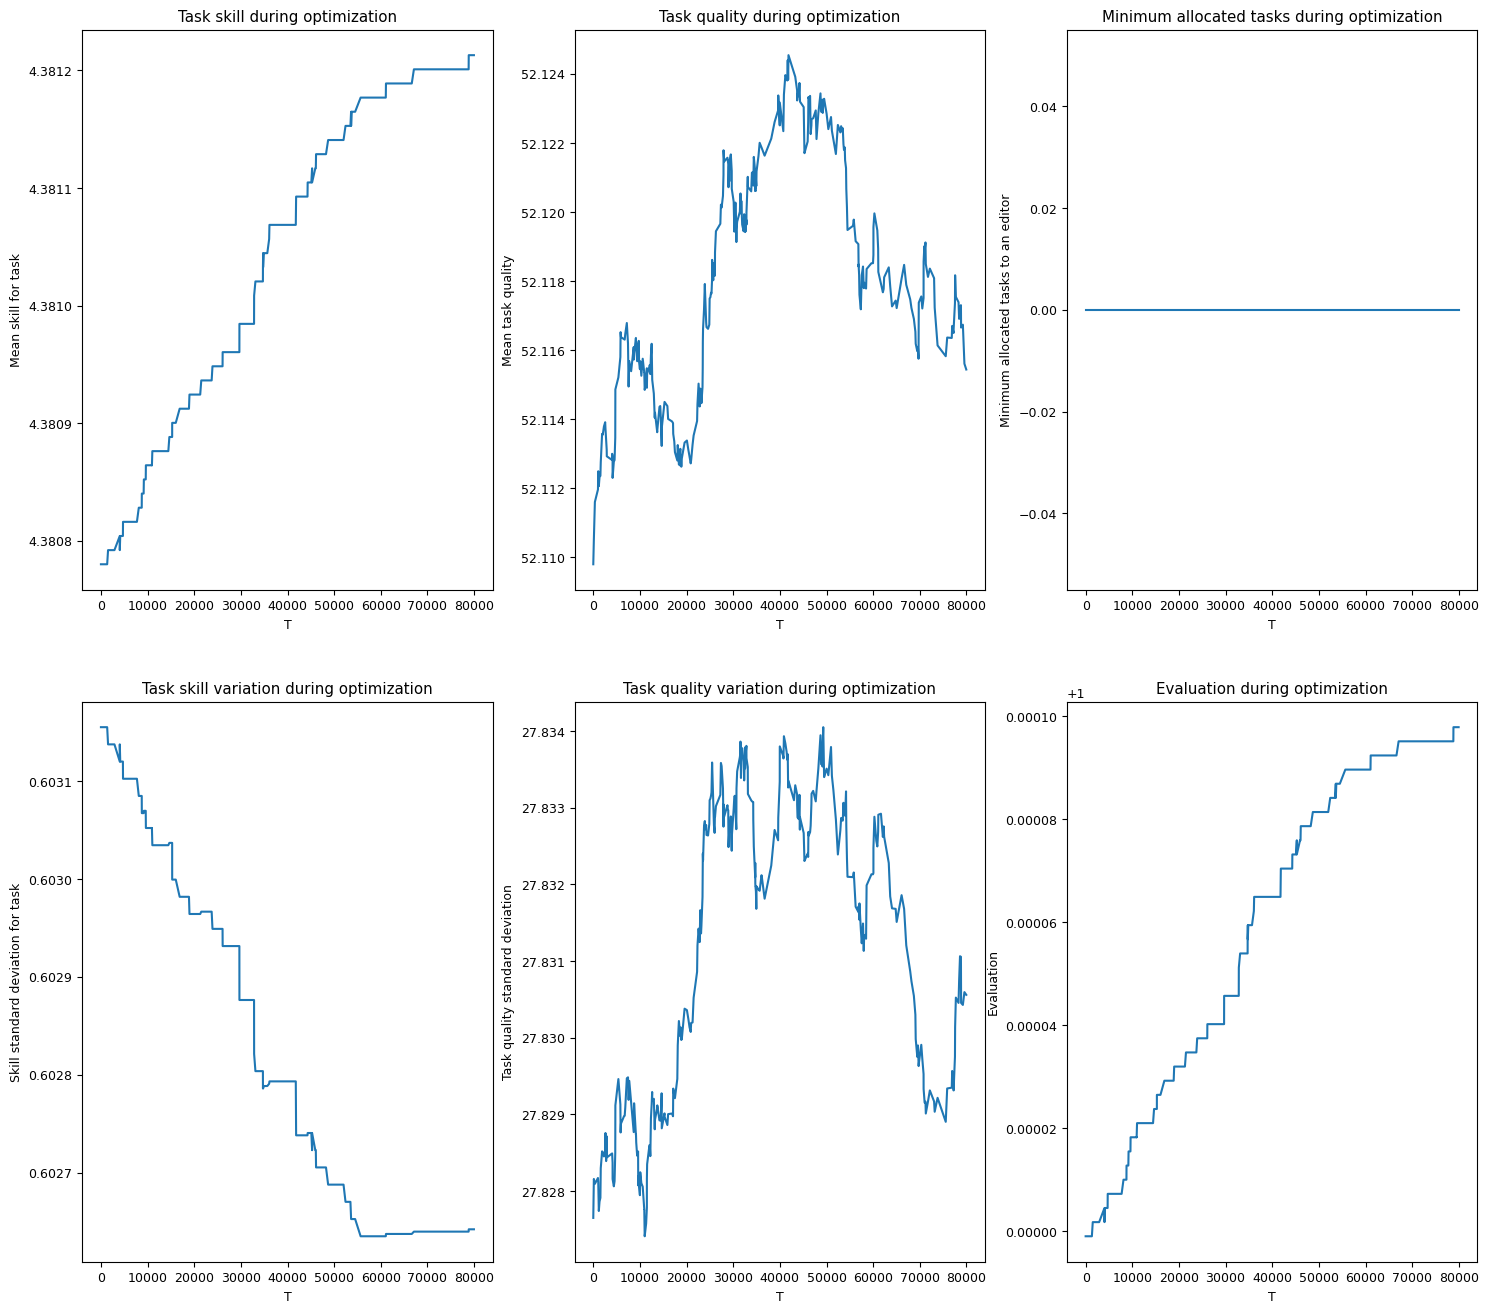

In [193]:
optimization_plots(evaluation_thr_stringent_df)

We can see that task quality has decreased in the travel, fintech and healthcare domains, which brought us $88.4\%$ of the tasks combined. Task quality has only increased in the remaining sectors, ecommerce, gaming and sports.

In [213]:
mean_quality_by_domain_after_stringent_optimization = tasks_all_optimized_table_strthr.groupby('domain')['quality_score'].mean().sort_values(ascending=False)
mean_quality_by_domain_after_stringent_optimization
final_mean_quality_comparison = pd.concat([mean_quality_comparison,mean_quality_by_domain_after_stringent_optimization],axis=1)
final_mean_quality_comparison.columns = mean_quality_comparison.columns.to_list() + ['After stringent optimization']
final_mean_quality_comparison

,Before Optimization,After Optimization,After stringent optimization
domain,,,
ecommerce,64.449055,64.454917,64.461473
health_care,64.343819,64.346038,64.401996
fintech,59.280373,59.300309,59.272386
gamming,59.106687,59.124718,58.970699
sports,58.160276,58.086345,58.175448
travel,41.733002,41.730354,41.732408


We have also reduced the number of editors with less than $62$ tasks to $153$.

In [195]:
post_editors_optimized_table_strthr[post_editors_optimized_table_strthr['tasks_allocated']<62]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated,sampling_weights
6,d75edf7bf3c340b56e8255f968b37576739bfc29914202...,1,1,3,4,3,3,pt_en,7,492
7,5379170989104e67c71efdba8d57bacb48c04ef350d91b...,3,2,2,2,1,3,fr_de,45,455
17,c1362802f35ff23bfcdf2ed37017c1be122c247fd8a6ac...,3,3,2,3,1,1,nl_en,52,448
24,23174ccee5dc5eb5890c33847903a3f3adadca3883d803...,2,2,4,3,1,4,nl_en,34,468
26,25627790d1bb57a598e312d881abb7f7debf117f3ebf4c...,1,4,1,3,1,2,pt_en,32,467
...,...,...,...,...,...,...,...,...,...,...
413,7a3bfb44ceb840fb01e49b03968396965cc51ad37f16ae...,1,2,2,1,1,4,fr_de,10,490
414,8ed50fc26c49d98c19987a11213aad4c5ef52c53122199...,1,2,4,1,1,4,pt_en,26,476
415,78ff5107579690a5982b2df3439111b985e2175a127db6...,1,2,4,1,1,4,nl_en,37,466
416,80503580365a55d01da92e418a5cac75a3c8450ebc1655...,1,2,4,1,1,4,nl_en,32,464


We are also left with $4$ low-skilled editors idle.

We see here that the stringent optimization did not improve task redistribution tasks to the least demanded editors.

In [196]:
post_editors_optimized_table_strthr[post_editors_optimized_table_strthr['tasks_allocated']==0]

,id,travel,fintech,ecommerce,sports,gamming,health_care,language_pair,tasks_allocated,sampling_weights
270,7d373d3809c88b4ca0cfe2fbf5a5f935e0d564cf98ae3b...,1,1,1,1,1,2,fr_de,0,500
273,19284b6dd552469e5d5b59869de29976e54a746eaddeb4...,1,1,1,1,3,3,nl_en,0,500
295,18c6c263c7824e254d665831f42f00110a6179ba97377b...,1,3,1,3,1,1,es_ja,0,500
302,53fa4cf1956c1eda52267e6e02cd58e84cd7ab7ff07646...,1,2,1,1,1,2,pt_en,0,500


The overall task skill was higher in the stringent optimization than in the regular one, as expected, for there was no global search in the beginning.

In [223]:
mean_skill_df = {'Before Optimization':tasks_all['editor_skill'].mean(),'After simulated annealing':tasks_all_optimized_table_thr['editor_skill'].mean(),'After stringent simulated annealing':tasks_all_optimized_table_strthr['editor_skill'].mean()}
mean_skill_df

{'Before Optimization': 4.380780007937176,
 'After simulated annealing': 4.381044580472142,
 'After stringent simulated annealing': 4.3812129448125745}

The overall difference in the mean skill is mostly due to the travel domain tasks. In all other domains, the results are similar.

In [224]:
mean_skill_by_domain_df = pd.DataFrame({'Before Optimization':tasks_all.groupby('domain')['editor_skill'].mean(),'After simulated annealing':tasks_all_optimized_table_thr.groupby('domain')['editor_skill'].mean(),'After stringent simulated annealing':tasks_all_optimized_table_strthr.groupby('domain')['editor_skill'].mean()})
mean_skill_by_domain_df

,Before Optimization,After simulated annealing,After stringent simulated annealing
domain,,,
ecommerce,4.810027,4.810336,4.810258
fintech,4.886898,4.887166,4.887099
gamming,4.877536,4.882795,4.882795
health_care,4.811353,4.813067,4.813168
sports,4.873379,4.875034,4.874483
travel,3.890316,3.889920,3.890340


Here is the new task assignment profile according to domain and editor skill.

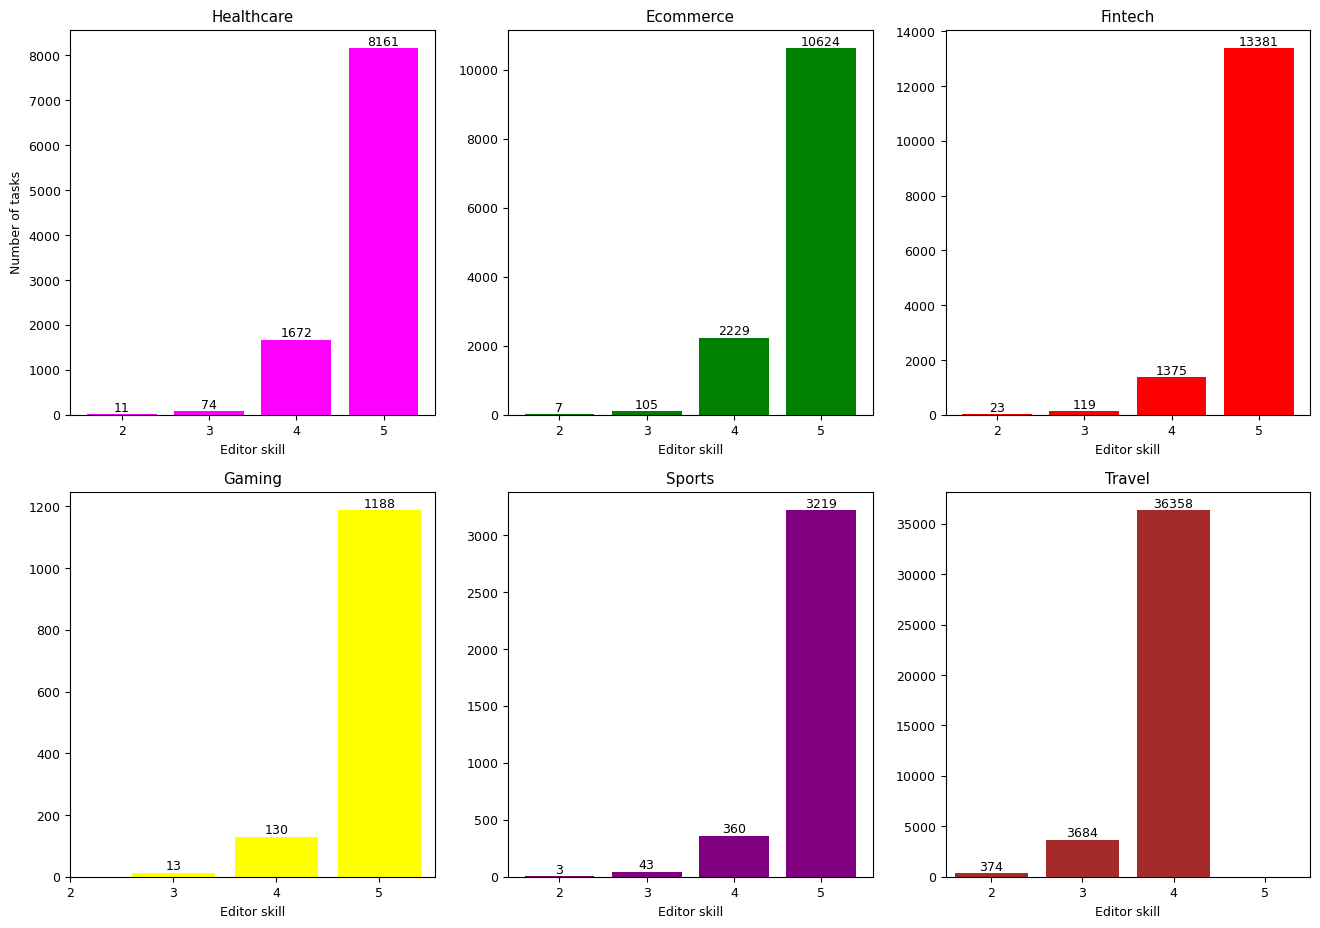

In [226]:
assignment_by_domain_plots(tasks_all_optimized_table_strthr)

In the table below we see the comparison of the number of assigned tasks by domain and skill shown above with the ones we had before. We can clearly see that the transfer of travel domain tasks to lower-skill editors did not take place in this stringent optimization. Therefore, mean task skill in the travel domain ended up being higher than under the regular simulated annealing. On all other domains, the assignment ended up having small differences due to chance, as the task reassignmet depends on random sampling.

In [214]:
final_task_assignment_skill = pd.DataFrame({'Before optimization':tasks_all.groupby('domain')['editor_skill'].value_counts().sort_index().values,
                                            'After simulated annealing':tasks_all_optimized_table_thr.groupby('domain')['editor_skill'].value_counts().sort_index().values,
                                            'After stringent simulated annealing':tasks_all_optimized_table_strthr.groupby('domain')['editor_skill'].value_counts().sort_index().values},
                                           index=tasks_all_optimized_table_strthr.groupby('domain')['editor_skill'].value_counts().sort_index().index)
final_task_assignment_skill

Before optimization  After simulated annealing  \
domain      editor_skill                                                   
ecommerce   2                               7                          7   
            3                             108                        104   
            4                            2226                       2230   
            5                           10624                      10624   
fintech     2                              23                         23   
            3                             122                        118   
            4                            1372                       1376   
            5                           13381                      13381   
gamming     3                              13                         12   
            4                             137                        132   
            5                            1181                       1187   
health_care 2                              14                         13   
            3                              86                         71   
            4                            1657                       1673   
            5                            8161                       8161   
sports      2                               3                          3   
            3                              44                         43   
            4                             362                        358   
            5                            3216                       3221   
travel      2                             375                        380   
            3                            3683                       3689   
            4                           36358                      36347   

                          After stringent simulated annealing  
domain      editor_skill                                       
ecommerce   2                                               7  
            3                                             105  
            4                                            2229  
            5                                           10624  
fintech     2                                              23  
            3                                             119  
            4                                            1375  
            5                                           13381  
gamming     3                                              13  
            4                                             130  
            5                                            1188  
health_care 2                                              11  
            3                                              74  
            4                                            1672  
            5                                            8161  
sports      2                                               3  
            3                                              43  
            4                                             360  
            5                                            3219  
travel      2                                             374  
            3                                            3684  
            4                                           36358

<a id='recommendations'></a>
# Recommendations

We can say that <font color = blue> the translation tasks can be stochastically assigned with an exponential function to weight our sampling based on the editor skill</font>. This task assignment modality has pretty much resolved the main complaints brought up by clients and editors:
- It virtually eliminates the group of idle editors, having left only $3$ low-skilled editors without tasks so far;
- It ensures high average task skill $-$ way above $4$ $-$, which leads to a very decent task quality;
- It gives conditions to the editors to deliver the tasks within the deadlines.

The typical simulated annealing optimization can improve the initial task assignment overall. However, the stringent optmization shows us that the initial global search brings us further from a single optimal level instead of bringing the task assignment to another optimal level. In our scenario, it seems we have a single, global optimal solution instead of having several optimal solutions, because our evaluation function has only increased when the Metropolis Criterion value became very close to zero, after around 2500 optimization cycles.

A stringent optimization procedure was the best way to go, given that the initial task assignment has already brought good results. This optimization procedure allowed us to achieve the highest average task skill, especially because it did not a low a transfer of travel domain tasks from higher- to lower-skill editors. Therefore, <font color = blue>we should use the stringent optimization procedure to further improve task assignment after the initial task assignment</font>.

The lack of skills in the travel sector has brought a relatively low average skill for tasks in this domain as a consequence. <font color = blue> The company should urgently recruit skill-$5$-editors in the travel domain </font>, not only because this is the only domain that has no skill-$5$-editors, but also because this is still the domain that is most in demand! I strongly believe this task assignment delivers the best average task quality in the travel sector, given the editor skills we have, but in the end no task assignment can fully compensate for the lack of skills. <font color = blue> As an alternative, the company can develop a learning / masterclass program to upskill its travel domain editors, so that at least some of the current skill-$4$-editors can become skill-$5$-editors and some skill-$1$ and skill-$2$-editors can become skill-$3$-editors </font>. Such a program seems quite feasible to me, given that there is no correlation between skill levels in different domains. We know that many of these low-skilled travel editors are actually highly-skilled in other domains, so they have low skills in the travel sector because they are unfamiliar with technical terms in that domain, not because they don't master the languages. Not taking aggressive action in this regard can severely hurt the company due to insufficient task quality on a sector that alone brings $48.0\%$ of the clients and $48.6\%$ of the tasks!

### Appendix: Task assignment optimization without threading

In [199]:
#from UnbabelOptimizer import task_optimization

#post_editors_optimized_table = post_editors.copy()
#tasks_all_optimized_table = tasks_all.copy()

In [200]:
#optimization_t0 = time.process_time()
#post_editors_optimized_table, tasks_all_optimized_table, evaluation_incredible_df = incredible_task_optimization(post_editors_optimized_table, tasks_all_optimized_table)
#print('Simulated annealing optimization took',time.process_time() - optimization_t0, 'seconds.')

In [201]:
#optimization_plots(evaluation_incredible_df)